In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import scipy.stats as stats
from sklearn import preprocessing
from tqdm import tqdm
import os
import pathlib
import re
import pandas as pd
import pickle
import csv
import statistics

In [4]:
import timeit

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

from sklearn.preprocessing import PolynomialFeatures

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.preprocessing import LabelBinarizer

import catboost as cb
from catboost import CatBoostClassifier

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
parent_path = str(pathlib.Path(os.getcwd()).parent)

rlist = []
records = os.path.normpath(parent_path + '/mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [12]:
performance_dict = {
    "Avg Accuracy": [],
    "Std Accuracy": [],
    "Sensitivity": [],
    "Specificity": [],
    "Precision": [],
    "F1 score": [],
    "Run time": [],
}

In [6]:
feature_dfs = {}
for record in tqdm(rlist):
    feature_dfs[record] = pd.read_csv(os.path.normpath(parent_path + '/mit-bih-time-features/'+record+'.csv'), index_col=0, dtype={'subjectID': str})

combined_features = pd.concat([feature_dfs[key][1:] for key in feature_dfs])

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 43.21it/s]


In [7]:
X = combined_features[['range']]
y = combined_features['mappedLabel'].map({"Non-Afib": 0, "Afib": 1})
groups = combined_features['subjectID'].astype('int64')

logo = LeaveOneGroupOut()
splits = list(logo.split(X, y, groups=groups))

In [17]:
# Logistic regression
start_time = timeit.default_timer()

logreg = LogisticRegression(solver='liblinear')

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    logreg.fit(X_train, y_train)
    pred_values = logreg.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.50it/s]


---Run time is 2.436473800102249 seconds ---

Accuracy of each fold: 
 [0.9773069036226931, 0.7622560916415881, 0.9742081447963801, 0.6973610331274565, 0.35209144579826657, 0.905596107055961, 0.2583501457072405, 0.7263054509739728, 0.32103676913803497, 0.9339410754392918, 0.03707338349144041, 0.809227579056506, 0.5021786492374728, 0.0, 0.000598503740648379, 0.2705932565087495, 0.457871213375269, 0.23414295628036086, 0.7589738389778949, 0.7527748414376322, 0.23235624553161066, 0.8550286922379946, 0.2558045628911771]
Avg accuracy: 0.5250033430464192
Std of accuracy : 
0.322021928756055
confusion matrix: 
[[94744  8141]
 [84125   547]]
classification report: 
              precision    recall  f1-score   support

           0       0.53      0.92      0.67    102885
           1       0.06      0.01      0.01     84672

    accuracy                           0.51    187557
   macro avg       0.30      0.46      0.34    187557
weighted avg       0.32      0.51      0.37    187557

0.920872

In [18]:
# Linear discriminant analysis
start_time = timeit.default_timer()

lda = LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    lda.fit(X_train, y_train)
    pred_values = lda.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.21it/s]


---Run time is 0.7781136000994593 seconds ---

Accuracy of each fold: 
 [0.9774436090225563, 0.7622560916415881, 0.9742081447963801, 0.7024143739472206, 0.35209144579826657, 0.905596107055961, 0.2583501457072405, 0.7333442461941398, 0.32103676913803497, 0.9347337825340204, 0.03707338349144041, 0.8128564022809746, 0.5021786492374728, 0.0, 0.000598503740648379, 0.2705932565087495, 0.46200960105942723, 0.23414295628036086, 0.7589738389778949, 0.7527748414376322, 0.23235624553161066, 0.8577469042585322, 0.2558045628911771]
Avg accuracy: 0.5260253852839708
Std of accuracy : 
0.3226113113211982
confusion matrix: 
[[94901  7984]
 [84132   540]]
classification report: 
              precision    recall  f1-score   support

           0       0.53      0.92      0.67    102885
           1       0.06      0.01      0.01     84672

    accuracy                           0.51    187557
   macro avg       0.30      0.46      0.34    187557
weighted avg       0.32      0.51      0.37    187557

0.9

In [19]:
# Quadratic discriminant analysis
start_time = timeit.default_timer()

qda = QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    qda.fit(X_train, y_train)
    pred_values = qda.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 64.19it/s]


---Run time is 0.36364300013519824 seconds ---

Accuracy of each fold: 
 [0.98796992481203, 0.7622560916415881, 0.9769230769230769, 0.686692869174621, 0.35184022107775403, 0.9054987834549878, 0.2587984756780991, 0.7194303486659027, 0.32103676913803497, 0.9789932619896948, 0.038163777123541597, 0.8168308277172974, 0.5021786492374728, 0.0, 0.000598503740648379, 0.2708066581306018, 0.45323621916901174, 0.23414295628036086, 0.7596836341512878, 0.7472251585623678, 0.23235624553161066, 0.8666565992147387, 0.25540076721179084]
Avg accuracy: 0.5272486877663703
Std of accuracy : 
0.32565844026850194
confusion matrix: 
[[95132  7753]
 [84127   545]]
classification report: 
              precision    recall  f1-score   support

           0       0.53      0.92      0.67    102885
           1       0.07      0.01      0.01     84672

    accuracy                           0.51    187557
   macro avg       0.30      0.47      0.34    187557
weighted avg       0.32      0.51      0.38    187557

0

In [20]:
# KNN-CV (k = 3, 5, 10)
for k in [3, 5, 10]:
    print('k is: ' + str(k))
    start_time = timeit.default_timer()

    knn = neighbors.KNeighborsClassifier(n_neighbors = k)

    acc_score = []
    Truth = []
    Output = []

    for train, test in tqdm(splits):
        X_train = X.iloc[train]
        y_train = y.iloc[train]

        X_test = X.iloc[test]
        y_test = y.iloc[test]

        knn.fit(X_train, y_train)
        pred_values = knn.predict(X_test)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        Truth.extend(y_test.values.reshape(y_test.shape[0])) 
        Output.extend(pred_values)

    elapsed = timeit.default_timer() - start_time

    print("---Run time is %s seconds ---" % elapsed)
    print()
    print('Accuracy of each fold: \n {}'.format(acc_score))
    print("Avg accuracy: {}".format(np.mean(acc_score)))
    print('Std of accuracy : \n{}'.format(np.std(acc_score)))
    print("confusion matrix: ")

    cm = confusion_matrix(Truth, Output)
    print(cm)
    print("classification report: ")
    print(classification_report(Truth, Output))

    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])
    f1_score = (2*precision*sensitivity)/(precision+sensitivity)

    print(sensitivity)
    print(specificity)
    print(precision)
    print(f1_score)

k is: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.26it/s]


---Run time is 5.4127986000385135 seconds ---

Accuracy of each fold: 
 [0.5123718386876281, 0.6471216386758567, 0.5588235294117647, 0.5739752947782145, 0.48436126114809697, 0.6581995133819951, 0.47377269670477473, 0.6233426092650188, 0.4274864376130199, 0.5212049147839873, 0.3666993784756297, 0.6236391912908242, 0.5046840958605664, 0.4416181428133619, 0.4570573566084788, 0.4632949210413999, 0.5172984605197815, 0.44580152671755724, 0.4758669641046441, 0.572938689217759, 0.4187519150240016, 0.593325279371791, 0.4702200686452655]
Avg accuracy: 0.5144285097452791
Std of accuracy : 
0.07741398887620457
confusion matrix: 
[[58865 44020]
 [47720 36952]]
classification report: 
              precision    recall  f1-score   support

           0       0.55      0.57      0.56    102885
           1       0.46      0.44      0.45     84672

    accuracy                           0.51    187557
   macro avg       0.50      0.50      0.50    187557
weighted avg       0.51      0.51      0.51    1

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.24it/s]


---Run time is 5.427752200048417 seconds ---

Accuracy of each fold: 
 [0.5097744360902255, 0.6716823609358314, 0.5564102564102564, 0.5985401459854015, 0.4784574802160533, 0.6829197080291971, 0.45438242546514235, 0.6488787035521362, 0.4198915009041591, 0.533491874752279, 0.33704067168247737, 0.6419561085190946, 0.50119825708061, 0.43671467974256817, 0.4516708229426434, 0.45550576184379, 0.5101804337030293, 0.42761970853573905, 0.47515716893125126, 0.5821881606765328, 0.40915126136247576, 0.6093325279371791, 0.4639612356147789]
Avg accuracy: 0.5154828561266457
Std of accuracy : 
0.09134440663656868
confusion matrix: 
[[60016 42869]
 [48776 35896]]
classification report: 
              precision    recall  f1-score   support

           0       0.55      0.58      0.57    102885
           1       0.46      0.42      0.44     84672

    accuracy                           0.51    187557
   macro avg       0.50      0.50      0.50    187557
weighted avg       0.51      0.51      0.51    18

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.14it/s]


---Run time is 5.561898399842903 seconds ---

Accuracy of each fold: 
 [0.6076555023923444, 0.7331327055625667, 0.6977375565610859, 0.6970802919708029, 0.43562366536867225, 0.7746958637469586, 0.384218785025779, 0.7881813717466034, 0.37010247136829416, 0.6288809618179416, 0.21317195507578235, 0.7639536893036115, 0.5124183006535947, 0.33879865154765554, 0.32728179551122194, 0.4209346991037132, 0.5608342989571263, 0.3759888965995836, 0.5039545731089029, 0.6516913319238901, 0.33898478194260034, 0.7154938085170643, 0.410761154855643]
Avg accuracy: 0.5326772657678887
Std of accuracy : 
0.17009701076848494
confusion matrix: 
[[71296 31589]
 [58236 26436]]
classification report: 
              precision    recall  f1-score   support

           0       0.55      0.69      0.61    102885
           1       0.46      0.31      0.37     84672

    accuracy                           0.52    187557
   macro avg       0.50      0.50      0.49    187557
weighted avg       0.51      0.52      0.50   

In [21]:
# Decision tree
start_time = timeit.default_timer()

decisionTree = DecisionTreeClassifier(max_depth=6) #criterion='entropy'

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    decisionTree.fit(X_train, y_train)
    pred_values = decisionTree.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.41it/s]


---Run time is 3.6021654000505805 seconds ---

Accuracy of each fold: 
 [0.4209159261790841, 0.7109018541889137, 0.9138763197586727, 0.847557551937114, 0.3953020977264163, 0.7546472019464721, 0.3291862811028917, 0.9492551972499591, 0.33056057866184446, 0.5860747787026027, 0.09431904917675281, 0.8653879384828063, 0.4984749455337691, 0.5536316273368066, 0.4805985037406484, 0.39714041826717883, 0.5422943221320974, 0.3092297015961138, 0.386331372946664, 0.6914640591966174, 0.23368399550607702, 0.8796436122017517, 0.3841106400161518]
Avg accuracy: 0.5458516510255393
Std of accuracy : 
0.23457340492737105
confusion matrix: 
[[71856 31029]
 [58147 26525]]
classification report: 
              precision    recall  f1-score   support

           0       0.55      0.70      0.62    102885
           1       0.46      0.31      0.37     84672

    accuracy                           0.52    187557
   macro avg       0.51      0.51      0.50    187557
weighted avg       0.51      0.52      0.51    

In [22]:
# bagging
start_time = timeit.default_timer()

bagging = RandomForestClassifier(max_features = 1, random_state = 2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    bagging.fit(X_train, y_train)
    pred_values = bagging.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [15:32<00:00, 40.52s/it]


---Run time is 932.0532951999921 seconds ---

Accuracy of each fold: 
 [0.5062200956937799, 0.6060576643044364, 0.5318250377073906, 0.5539023020774846, 0.4916467780429594, 0.6138199513381996, 0.4909213180901143, 0.5933868063512849, 0.4525617842073538, 0.5087858369665742, 0.40071965979718677, 0.585277345775013, 0.501525054466231, 0.45142506895494944, 0.461645885286783, 0.4765258215962441, 0.5058765105115047, 0.46412213740458014, 0.481748124112756, 0.5553646934460887, 0.4459197221938515, 0.5637269707037149, 0.482434887946699]
Avg accuracy: 0.50980171552066
Std of accuracy : 
0.055434479173288406
confusion matrix: 
[[56746 46139]
 [46231 38441]]
classification report: 
              precision    recall  f1-score   support

           0       0.55      0.55      0.55    102885
           1       0.45      0.45      0.45     84672

    accuracy                           0.51    187557
   macro avg       0.50      0.50      0.50    187557
weighted avg       0.51      0.51      0.51    187557

In [23]:
# AdaBoost
start_time = timeit.default_timer()

adaBoost = AdaBoostClassifier(n_estimators=500, learning_rate = 0.1, algorithm="SAMME.R", random_state=2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    adaBoost.fit(X_train, y_train)
    pred_values = adaBoost.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [08:33<00:00, 22.33s/it]


---Run time is 513.6512368998956 seconds ---

Accuracy of each fold: 
 [0.3801777170198223, 0.744879137947772, 0.9354449472096531, 0.8034811903425042, 0.39756312021102874, 0.7684671532846715, 0.3267204662631697, 0.9490915043378622, 0.3309222423146474, 0.5943982031972519, 0.11078399302148076, 0.8717815794021082, 0.4992374727668845, 0.5753907447134539, 0.000598503740648379, 0.39500640204865556, 0.5485846714120178, 0.323941707147814, 0.3888663557087812, 0.696353065539112, 0.23358186089265653, 0.8784355179704016, 0.3768423177871997]
Avg accuracy: 0.5274152119251998
Std of accuracy : 
0.2604317022654541
confusion matrix: 
[[71551 31334]
 [62128 22544]]
classification report: 
              precision    recall  f1-score   support

           0       0.54      0.70      0.60    102885
           1       0.42      0.27      0.33     84672

    accuracy                           0.50    187557
   macro avg       0.48      0.48      0.47    187557
weighted avg       0.48      0.50      0.48    1

In [24]:
# Gradient boost (sklearn)
start_time = timeit.default_timer()

gradientBoost = GradientBoostingClassifier(n_estimators = 500, 
                                           learning_rate = 0.1, 
                                           max_depth = 4, 
                                           random_state = 2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    gradientBoost.fit(X_train, y_train)
    pred_values = gradientBoost.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [20:24<00:00, 53.22s/it]


---Run time is 1224.1003304999322 seconds ---

Accuracy of each fold: 
 [0.4, 0.7482768663236579, 0.9060331825037707, 0.7974452554744526, 0.40434618766486624, 0.7711922141119222, 0.3317641784353284, 0.9338680635128499, 0.3298372513562387, 0.5945303210463734, 0.11896194526223967, 0.862450319682046, 0.5027233115468409, 0.5064357952804168, 0.32418952618453867, 0.40290226205719165, 0.5530541301109088, 0.3247744621790423, 0.3959643074427094, 0.6897463002114165, 0.23858645695026046, 0.8625792811839323, 0.38118312134060167]
Avg accuracy: 0.5382975973852872
Std of accuracy : 
0.23215298485319683
confusion matrix: 
[[71147 31738]
 [58795 25877]]
classification report: 
              precision    recall  f1-score   support

           0       0.55      0.69      0.61    102885
           1       0.45      0.31      0.36     84672

    accuracy                           0.52    187557
   macro avg       0.50      0.50      0.49    187557
weighted avg       0.50      0.52      0.50    187557

0.69

In [ ]:
# SVM tuned
start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_distributions = dict(gamma=gamma_range, C=C_range)

randomsearch = RandomizedSearchCV(SVC(cache_size=1000), param_distributions=param_distributions, cv=splits)
randomsearch.fit(X, y)

results = pd.DataFrame(randomsearch.cv_results_)
#best_results = results.iloc[randomsearch.best_index_]

for train, test in tqdm(splits):
    X_test = X.iloc[test]
    y_test = y.iloc[test]

    pred_values = randomsearch.best_estimator_.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    print(acc)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

In [ ]:
# SVM
start_time = timeit.default_timer()

svc = SVC(cache_size=3000)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    svc.fit(X_train, y_train)

    pred_values = svc.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    print(acc)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

1.5.1


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

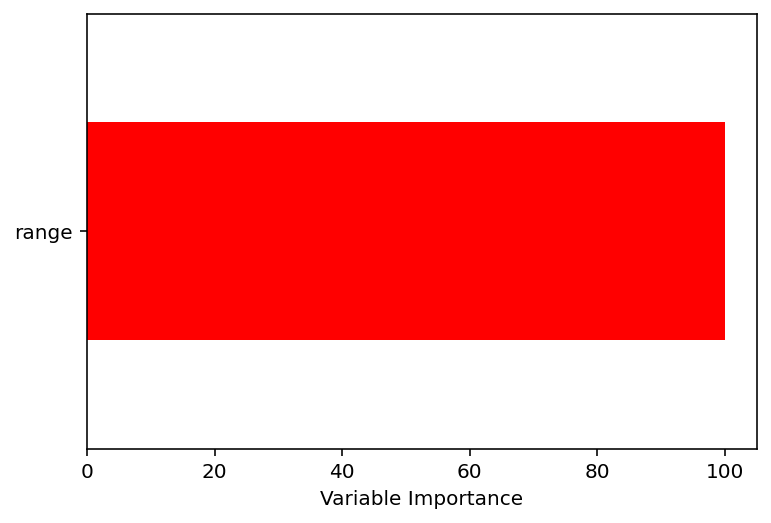

  4%|███▌                                                                               | 1/23 [00:03<01:27,  3.98s/it]

roc_auc_score 0.41420116482382985


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


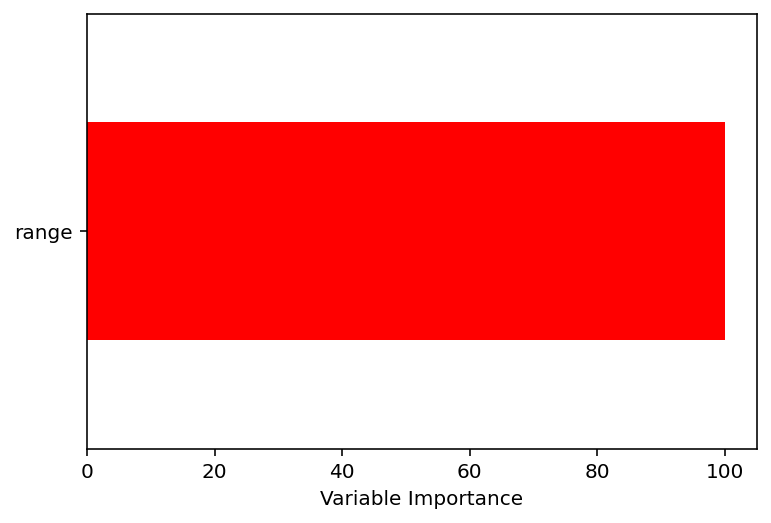

  9%|███████▏                                                                           | 2/23 [00:07<01:22,  3.95s/it]

roc_auc_score 0.8066455592195927


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


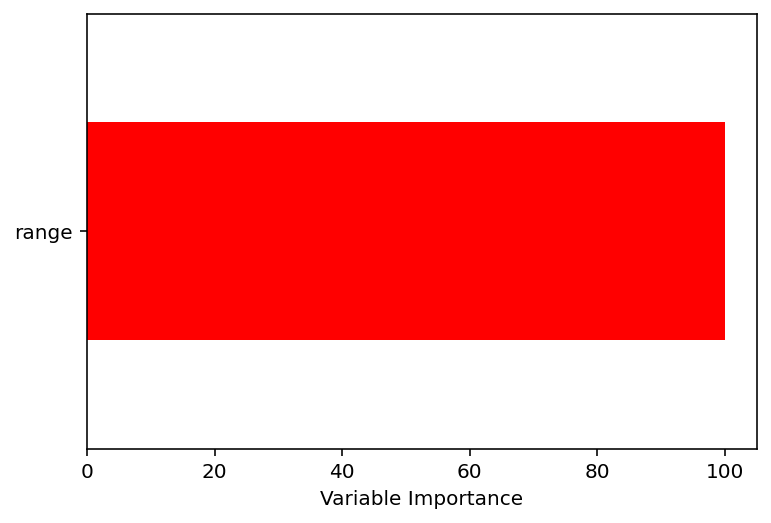

 13%|██████████▊                                                                        | 3/23 [00:11<01:18,  3.95s/it]

roc_auc_score 0.5862669289767057


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


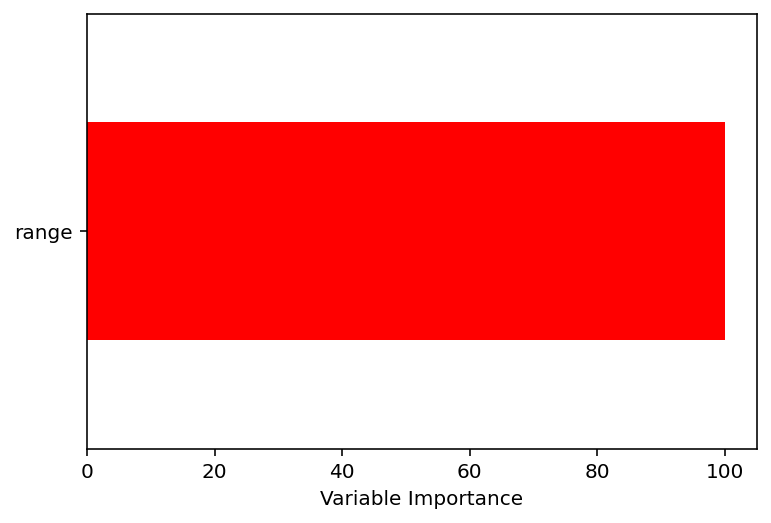

 17%|██████████████▍                                                                    | 4/23 [00:16<01:17,  4.07s/it]

roc_auc_score 0.5624961697033398


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


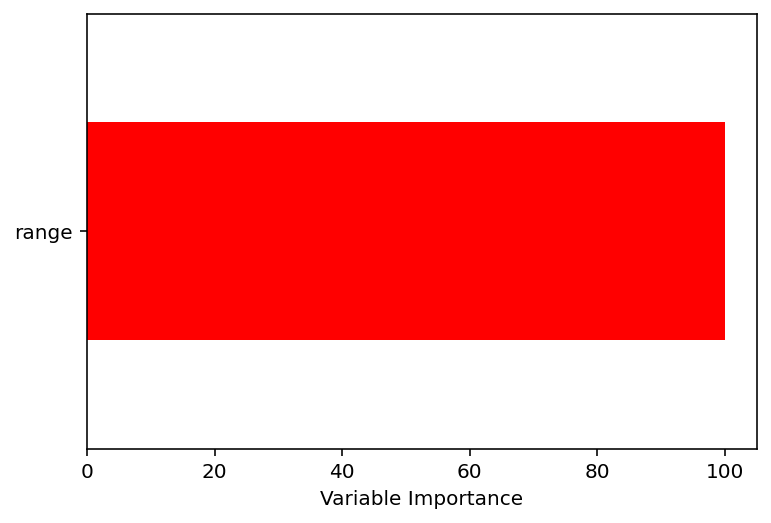

 22%|██████████████████                                                                 | 5/23 [00:20<01:15,  4.21s/it]

roc_auc_score 0.5306380473772578


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


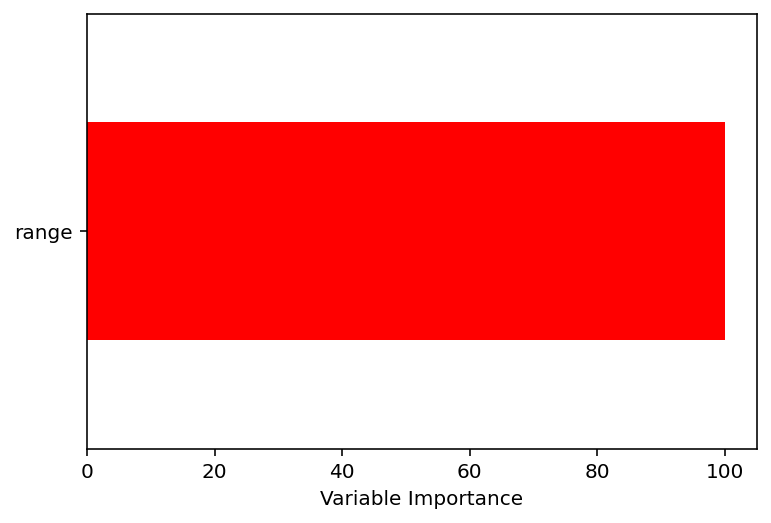

 26%|█████████████████████▋                                                             | 6/23 [00:25<01:13,  4.30s/it]

roc_auc_score 0.851180553632068


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


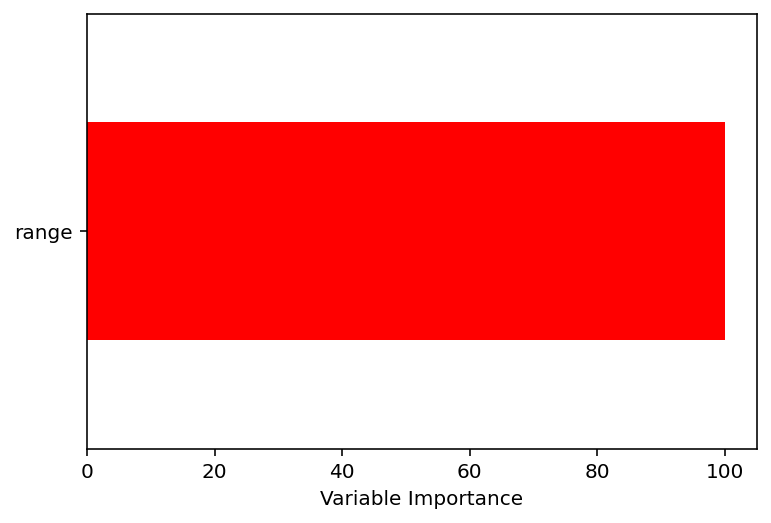

 30%|█████████████████████████▎                                                         | 7/23 [00:29<01:09,  4.34s/it]

roc_auc_score 0.6921797297143846


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


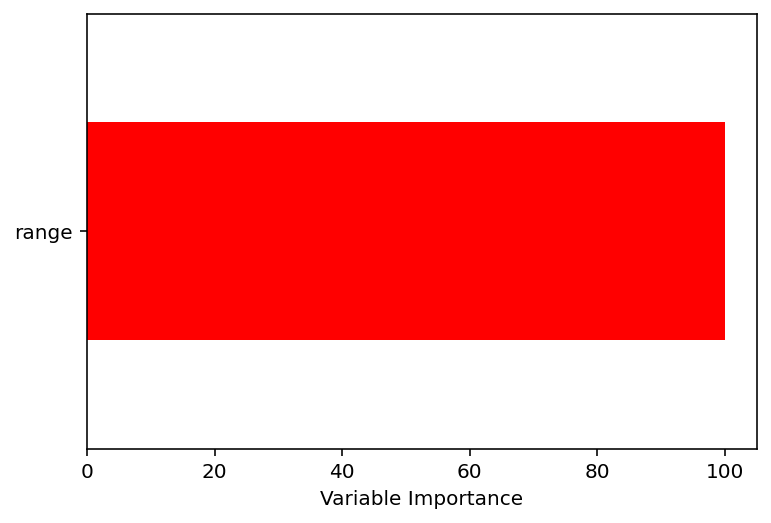

 35%|████████████████████████████▊                                                      | 8/23 [00:34<01:06,  4.40s/it]

roc_auc_score 0.677785080512652


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


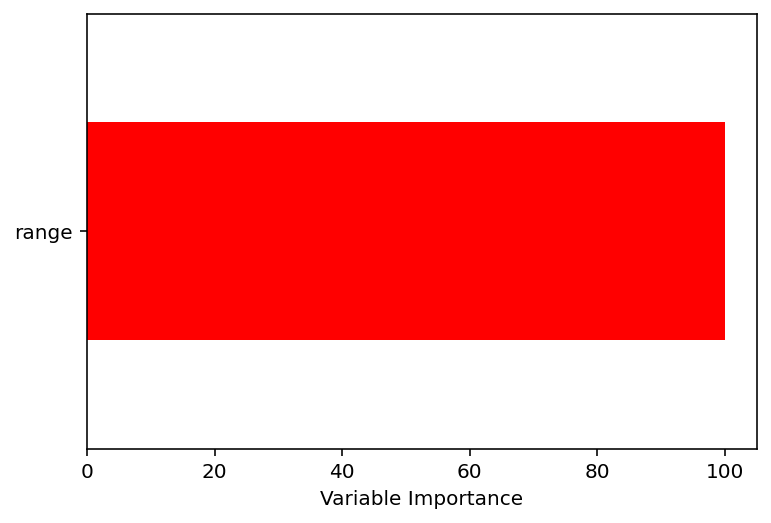

 39%|████████████████████████████████▍                                                  | 9/23 [00:38<01:02,  4.44s/it]

roc_auc_score 0.36992526211466903


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


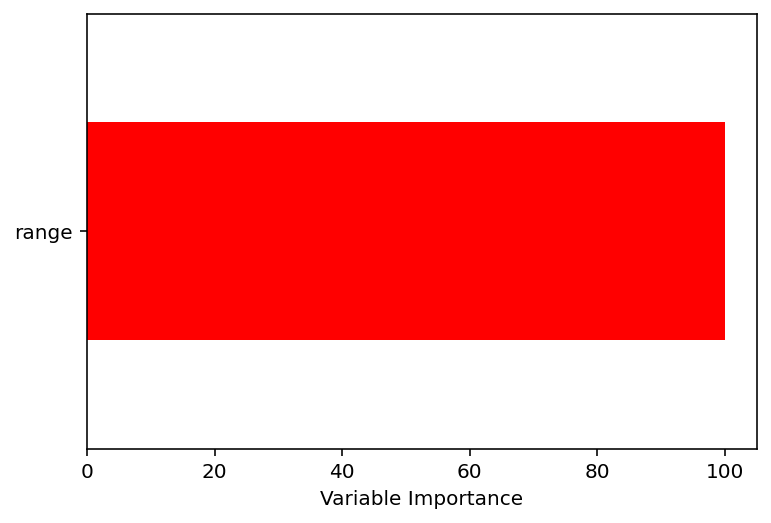

 43%|███████████████████████████████████▋                                              | 10/23 [00:42<00:57,  4.43s/it]

roc_auc_score 0.6549270491177145


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


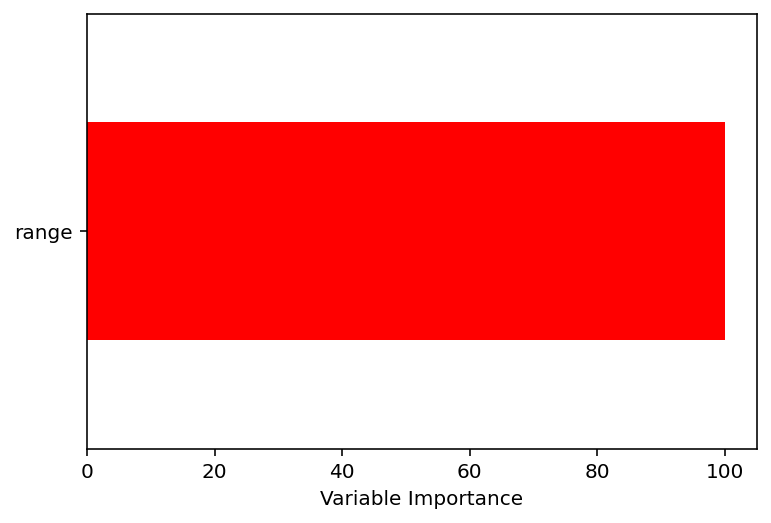

 48%|███████████████████████████████████████▏                                          | 11/23 [00:47<00:53,  4.43s/it]

roc_auc_score 0.583894862172982


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


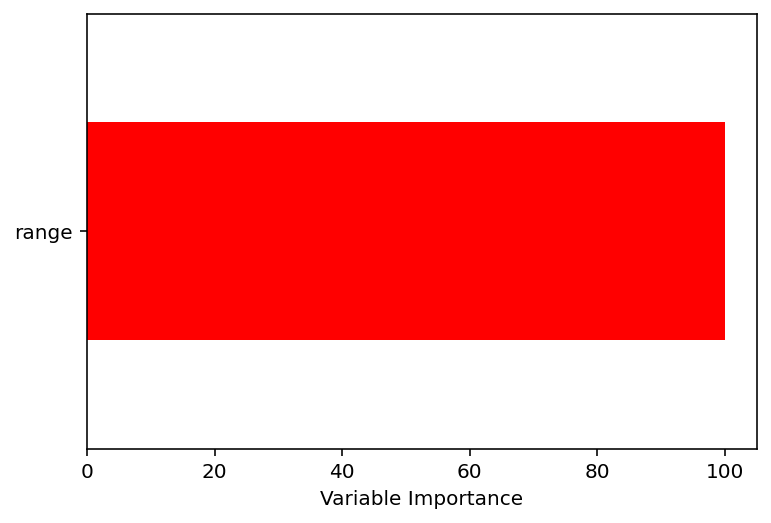

 52%|██████████████████████████████████████████▊                                       | 12/23 [00:51<00:48,  4.44s/it]

roc_auc_score 0.5873943258854865


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


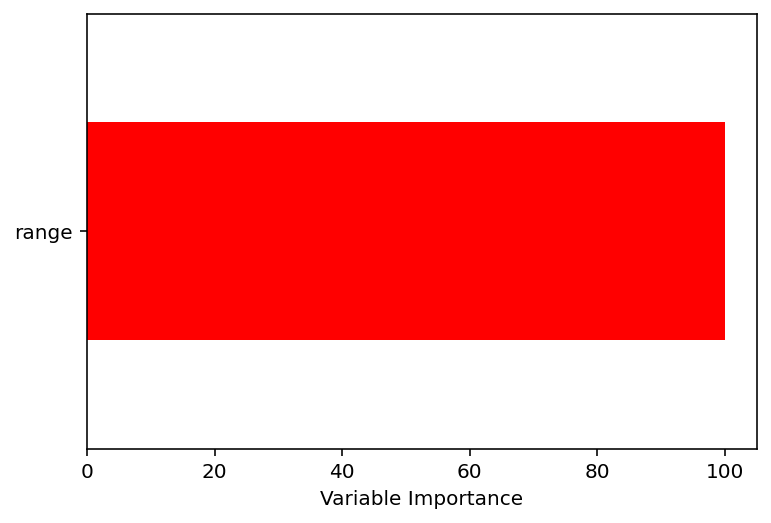

 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:56<00:44,  4.43s/it]

roc_auc_score 0.5287200548707263


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


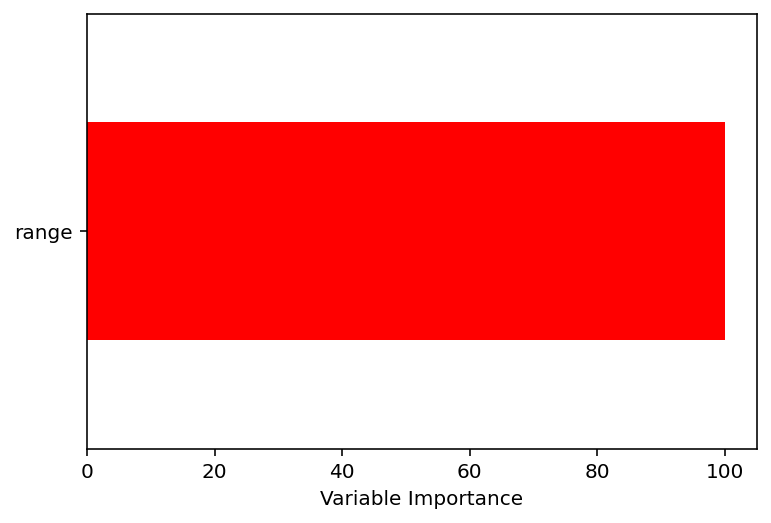

 70%|█████████████████████████████████████████████████████████                         | 16/23 [01:00<00:19,  2.76s/it]

roc_auc_score 0.43184384957342736


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


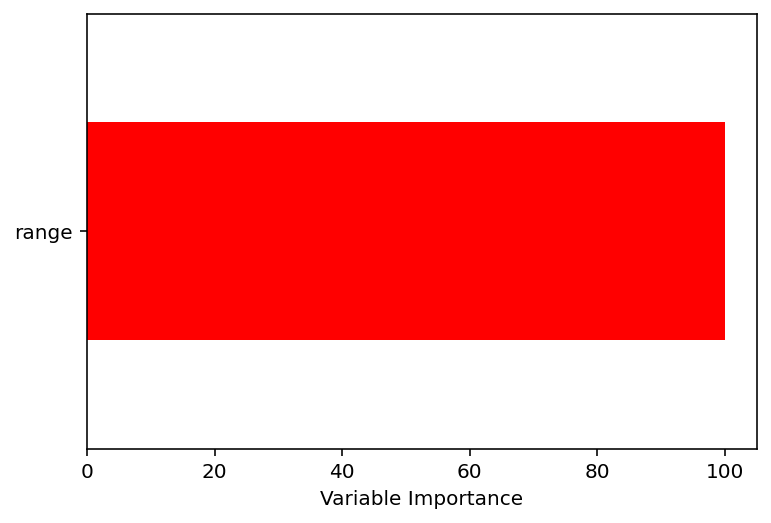

 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [01:05<00:18,  3.12s/it]

roc_auc_score 0.41815102640302293


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


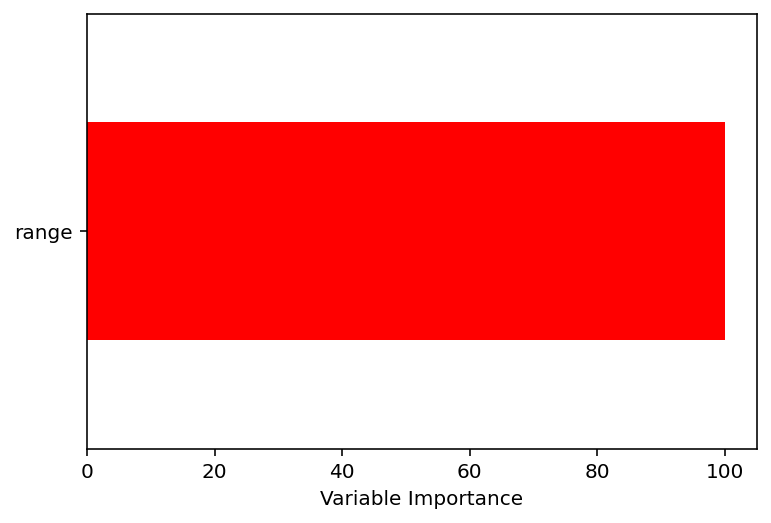

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [01:09<00:17,  3.43s/it]

roc_auc_score 0.306513328261466


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


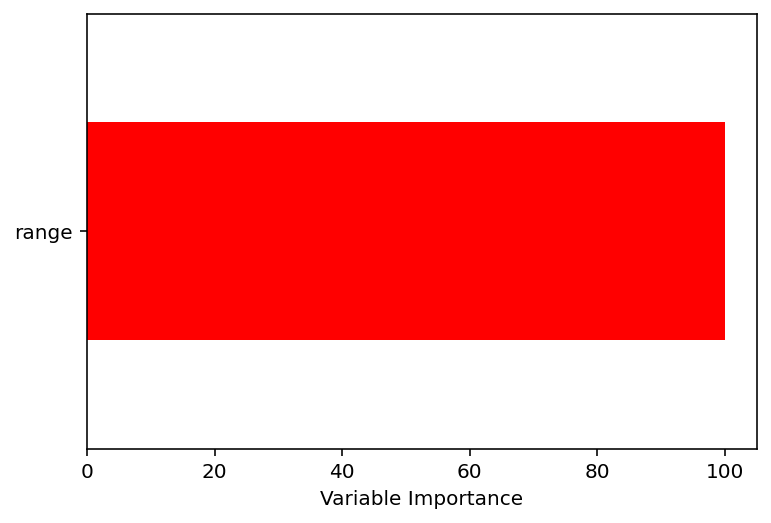

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [01:14<00:14,  3.69s/it]

roc_auc_score 0.5673686813050658


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


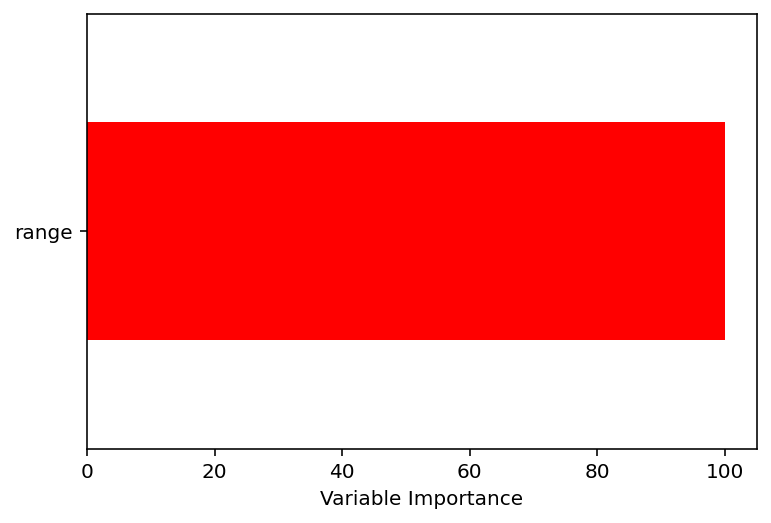

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [01:18<00:11,  3.91s/it]

roc_auc_score 0.6159697966771169


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


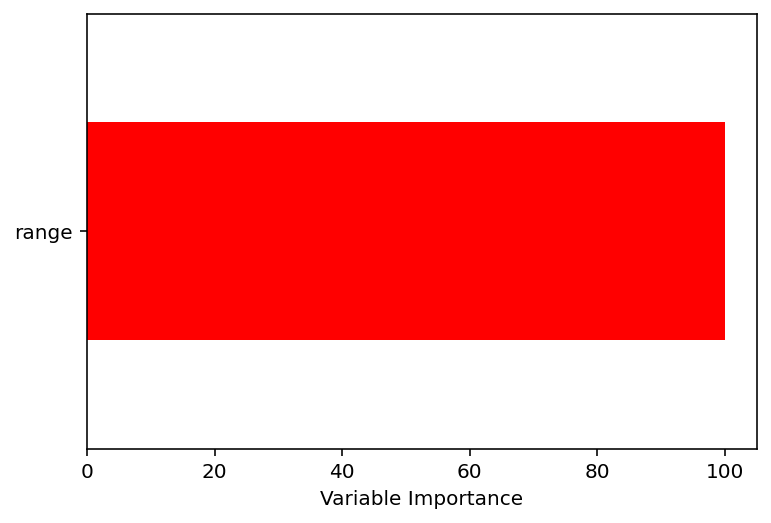

 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [01:22<00:08,  4.03s/it]

roc_auc_score 0.22087795121323595


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


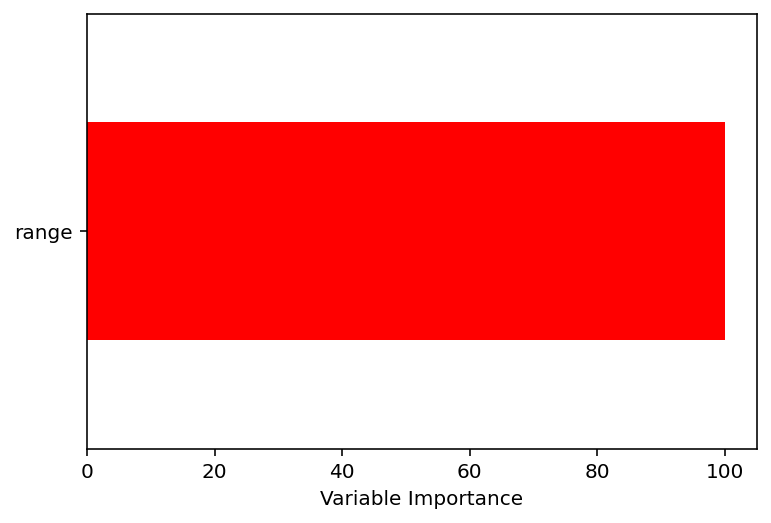

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [01:27<00:04,  4.15s/it]

roc_auc_score 0.8181210163894146


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


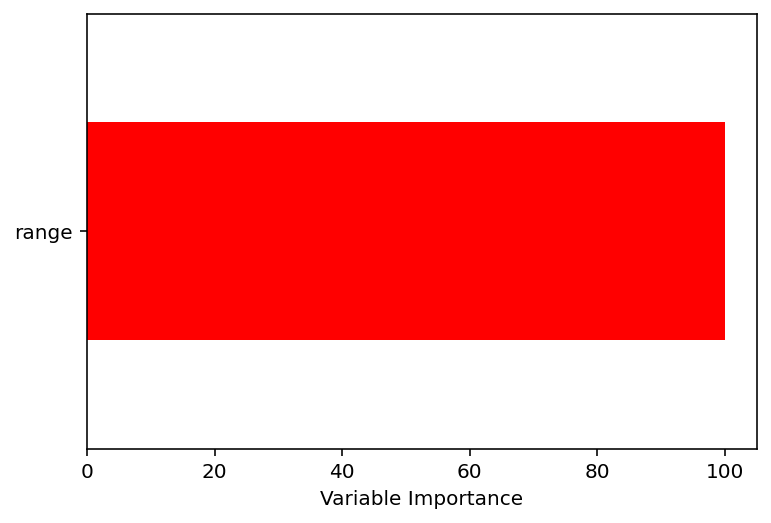

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:31<00:00,  3.99s/it]

roc_auc_score 0.38212526150403403
---Run time is 91.73160249995999 seconds ---

Accuracy of each fold: 
 [0.38646616541353385, 0.7464323852053198, 0.934238310708899, 0.8033408197641775, 0.3959301595276975, 0.779756690997567, 0.33109168347904055, 0.9477819610410869, 0.32814948764315854, 0.5922843176113093, 0.11143822920074146, 0.8712631760843269, 0.5003267973856209, 0.40172855313700384, 0.5530541301109088, 0.3325468424705066, 0.38917055364023523, 0.6958245243128964, 0.23307118782555408, 0.8758683177287828, 0.3805774278215223]

Avg accuracy : 
0.5519210343385663

Std of accuracy : 
0.24499924256362834
confusion matrix: 
[[71591 31294]
 [49051 19070]]
classification report: 


              precision    recall  f1-score   support

           0       0.59      0.70      0.64    102885
           1       0.38      0.28      0.32     68121

    accuracy                           0.53    171006
   macro avg       0.49      0.49      0.48    171006
weighted avg       0.51      0.53      0.51    171006



In [14]:
# XGBoost
print(xgb.__version__)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')

start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    a = y_test.to_numpy() # s.values (pandas<0.24)
    if (a[0] == a).all():
        continue
    
    model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    plt.show()
    #plt.savefig('plot1.png')
    
    ##################################################
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    
    # calculate the fpr and tpr for all thresholds of the classification
    #fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
    #roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    #import matplotlib.pyplot as plt
    #plt.title('Receiver Operating Characteristic')
    #plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([-0.05, 1])
    #plt.ylim([0, 1.05])
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.show()
    ##################################################
    
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

[0]	validation_0-logloss:0.69221	validation_1-logloss:0.68417
[1]	validation_0-logloss:0.69277	validation_1-logloss:0.67680
[2]	validation_0-logloss:0.69214	validation_1-logloss:0.67073
[3]	validation_0-logloss:0.69167	validation_1-logloss:0.66575


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[4]	validation_0-logloss:0.69167	validation_1-logloss:0.66158
[5]	validation_0-logloss:0.69148	validation_1-logloss:0.65815
[6]	validation_0-logloss:0.69263	validation_1-logloss:0.65530
[7]	validation_0-logloss:0.69355	validation_1-logloss:0.65291
[8]	validation_0-logloss:0.69434	validation_1-logloss:0.65088
[9]	validation_0-logloss:0.69436	validation_1-logloss:0.64920
[10]	validation_0-logloss:0.69524	validation_1-logloss:0.64780
[11]	validation_0-logloss:0.69608	validation_1-logloss:0.64666
[12]	validation_0-logloss:0.69677	validation_1-logloss:0.64560
[13]	validation_0-logloss:0.69743	validation_1-logloss:0.64475
[14]	validation_0-logloss:0.69801	validation_1-logloss:0.64403
[15]	validation_0-logloss:0.69780	validation_1-logloss:0.64342
[16]	validation_0-logloss:0.69848	validation_1-logloss:0.64292
[17]	validation_0-logloss:0.69911	validation_1-logloss:0.64250
[18]	validation_0-logloss:0.69964	validation_1-logloss:0.64214
[19]	validation_0-logloss:0.69956	validation_1-logloss:0.6418

  4%|███▌                                                                               | 1/23 [00:04<01:44,  4.76s/it]

[0]	validation_0-logloss:0.67426	validation_1-logloss:0.68588
[1]	validation_0-logloss:0.65802	validation_1-logloss:0.67989
[2]	validation_0-logloss:0.64359	validation_1-logloss:0.67495


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.63192	validation_1-logloss:0.67091
[4]	validation_0-logloss:0.62045	validation_1-logloss:0.66749
[5]	validation_0-logloss:0.61095	validation_1-logloss:0.66479
[6]	validation_0-logloss:0.60267	validation_1-logloss:0.66255
[7]	validation_0-logloss:0.59546	validation_1-logloss:0.66070
[8]	validation_0-logloss:0.58928	validation_1-logloss:0.65914
[9]	validation_0-logloss:0.58382	validation_1-logloss:0.65786
[10]	validation_0-logloss:0.57930	validation_1-logloss:0.65657
[11]	validation_0-logloss:0.57534	validation_1-logloss:0.65553
[12]	validation_0-logloss:0.57169	validation_1-logloss:0.65465
[13]	validation_0-logloss:0.56918	validation_1-logloss:0.65386
[14]	validation_0-logloss:0.56693	validation_1-logloss:0.65320
[15]	validation_0-logloss:0.56465	validation_1-logloss:0.65263
[16]	validation_0-logloss:0.56282	validation_1-logloss:0.65215
[17]	validation_0-logloss:0.56015	validation_1-logloss:0.65178
[18]	validation_0-logloss:0.55827	validation_1-logloss:0.65142

  9%|███████▏                                                                           | 2/23 [00:09<01:37,  4.64s/it]

[0]	validation_0-logloss:0.68656	validation_1-logloss:0.68443
[1]	validation_0-logloss:0.68079	validation_1-logloss:0.67731
[2]	validation_0-logloss:0.67566	validation_1-logloss:0.67150


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.67111	validation_1-logloss:0.66669
[4]	validation_0-logloss:0.66713	validation_1-logloss:0.66270
[5]	validation_0-logloss:0.66356	validation_1-logloss:0.65940
[6]	validation_0-logloss:0.66120	validation_1-logloss:0.65662
[7]	validation_0-logloss:0.65840	validation_1-logloss:0.65429
[8]	validation_0-logloss:0.65653	validation_1-logloss:0.65241
[9]	validation_0-logloss:0.65406	validation_1-logloss:0.65081
[10]	validation_0-logloss:0.65195	validation_1-logloss:0.64944
[11]	validation_0-logloss:0.65006	validation_1-logloss:0.64831
[12]	validation_0-logloss:0.64926	validation_1-logloss:0.64731
[13]	validation_0-logloss:0.64767	validation_1-logloss:0.64650
[14]	validation_0-logloss:0.64621	validation_1-logloss:0.64581
[15]	validation_0-logloss:0.64544	validation_1-logloss:0.64525
[16]	validation_0-logloss:0.64475	validation_1-logloss:0.64477
[17]	validation_0-logloss:0.64367	validation_1-logloss:0.64432
[18]	validation_0-logloss:0.64307	validation_1-logloss:0.64397

 13%|██████████▊                                                                        | 3/23 [00:13<01:33,  4.66s/it]

[0]	validation_0-logloss:0.68323	validation_1-logloss:0.68476
[1]	validation_0-logloss:0.67487	validation_1-logloss:0.67781
[2]	validation_0-logloss:0.66791	validation_1-logloss:0.67212


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.66205	validation_1-logloss:0.66733
[4]	validation_0-logloss:0.65819	validation_1-logloss:0.66332
[5]	validation_0-logloss:0.65367	validation_1-logloss:0.65979
[6]	validation_0-logloss:0.64998	validation_1-logloss:0.65689
[7]	validation_0-logloss:0.64698	validation_1-logloss:0.65445
[8]	validation_0-logloss:0.64532	validation_1-logloss:0.65251
[9]	validation_0-logloss:0.64315	validation_1-logloss:0.65081
[10]	validation_0-logloss:0.64226	validation_1-logloss:0.64937
[11]	validation_0-logloss:0.64142	validation_1-logloss:0.64816
[12]	validation_0-logloss:0.64078	validation_1-logloss:0.64712
[13]	validation_0-logloss:0.64016	validation_1-logloss:0.64632
[14]	validation_0-logloss:0.63988	validation_1-logloss:0.64558
[15]	validation_0-logloss:0.63950	validation_1-logloss:0.64496
[16]	validation_0-logloss:0.63931	validation_1-logloss:0.64441
[17]	validation_0-logloss:0.63858	validation_1-logloss:0.64396
[18]	validation_0-logloss:0.63860	validation_1-logloss:0.64360

 17%|██████████████▍                                                                    | 4/23 [00:18<01:28,  4.64s/it]

[0]	validation_0-logloss:0.69649	validation_1-logloss:0.68346
[1]	validation_0-logloss:0.69996	validation_1-logloss:0.67553
[2]	validation_0-logloss:0.70351	validation_1-logloss:0.66904


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.70714	validation_1-logloss:0.66361
[4]	validation_0-logloss:0.71068	validation_1-logloss:0.65911
[5]	validation_0-logloss:0.71407	validation_1-logloss:0.65537
[6]	validation_0-logloss:0.71736	validation_1-logloss:0.65224
[7]	validation_0-logloss:0.72077	validation_1-logloss:0.64975
[8]	validation_0-logloss:0.72355	validation_1-logloss:0.64757
[9]	validation_0-logloss:0.72653	validation_1-logloss:0.64582
[10]	validation_0-logloss:0.72904	validation_1-logloss:0.64425
[11]	validation_0-logloss:0.73168	validation_1-logloss:0.64302
[12]	validation_0-logloss:0.73374	validation_1-logloss:0.64189
[13]	validation_0-logloss:0.73554	validation_1-logloss:0.64096
[14]	validation_0-logloss:0.73759	validation_1-logloss:0.64018
[15]	validation_0-logloss:0.73908	validation_1-logloss:0.63951
[16]	validation_0-logloss:0.74070	validation_1-logloss:0.63892
[17]	validation_0-logloss:0.74197	validation_1-logloss:0.63845
[18]	validation_0-logloss:0.74332	validation_1-logloss:0.63800

 22%|██████████████████                                                                 | 5/23 [00:23<01:23,  4.64s/it]

[0]	validation_0-logloss:0.67437	validation_1-logloss:0.68681
[1]	validation_0-logloss:0.65764	validation_1-logloss:0.68161
[2]	validation_0-logloss:0.64377	validation_1-logloss:0.67738


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.63108	validation_1-logloss:0.67378
[4]	validation_0-logloss:0.62132	validation_1-logloss:0.67030
[5]	validation_0-logloss:0.61190	validation_1-logloss:0.66740
[6]	validation_0-logloss:0.60454	validation_1-logloss:0.66500
[7]	validation_0-logloss:0.59728	validation_1-logloss:0.66296
[8]	validation_0-logloss:0.59105	validation_1-logloss:0.66126
[9]	validation_0-logloss:0.58496	validation_1-logloss:0.65989
[10]	validation_0-logloss:0.58001	validation_1-logloss:0.65865
[11]	validation_0-logloss:0.57598	validation_1-logloss:0.65765
[12]	validation_0-logloss:0.57212	validation_1-logloss:0.65679
[13]	validation_0-logloss:0.56908	validation_1-logloss:0.65608
[14]	validation_0-logloss:0.56548	validation_1-logloss:0.65546
[15]	validation_0-logloss:0.56253	validation_1-logloss:0.65495
[16]	validation_0-logloss:0.55954	validation_1-logloss:0.65451
[17]	validation_0-logloss:0.55672	validation_1-logloss:0.65413
[18]	validation_0-logloss:0.55453	validation_1-logloss:0.65382

 26%|█████████████████████▋                                                             | 6/23 [00:27<01:19,  4.65s/it]

[0]	validation_0-logloss:0.69698	validation_1-logloss:0.68292
[1]	validation_0-logloss:0.70190	validation_1-logloss:0.67459
[2]	validation_0-logloss:0.70741	validation_1-logloss:0.66782


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.71366	validation_1-logloss:0.66223
[4]	validation_0-logloss:0.71956	validation_1-logloss:0.65747
[5]	validation_0-logloss:0.72536	validation_1-logloss:0.65350
[6]	validation_0-logloss:0.73144	validation_1-logloss:0.65025
[7]	validation_0-logloss:0.73718	validation_1-logloss:0.64753
[8]	validation_0-logloss:0.74248	validation_1-logloss:0.64527
[9]	validation_0-logloss:0.74788	validation_1-logloss:0.64333
[10]	validation_0-logloss:0.75250	validation_1-logloss:0.64176
[11]	validation_0-logloss:0.75696	validation_1-logloss:0.64040
[12]	validation_0-logloss:0.76165	validation_1-logloss:0.63929
[13]	validation_0-logloss:0.76546	validation_1-logloss:0.63833
[14]	validation_0-logloss:0.76928	validation_1-logloss:0.63756
[15]	validation_0-logloss:0.77295	validation_1-logloss:0.63688
[16]	validation_0-logloss:0.77692	validation_1-logloss:0.63633
[17]	validation_0-logloss:0.77989	validation_1-logloss:0.63587
[18]	validation_0-logloss:0.78302	validation_1-logloss:0.63545

 30%|█████████████████████████▎                                                         | 7/23 [00:32<01:13,  4.61s/it]

[0]	validation_0-logloss:0.68143	validation_1-logloss:0.68515
[1]	validation_0-logloss:0.66807	validation_1-logloss:0.67855
[2]	validation_0-logloss:0.65916	validation_1-logloss:0.67310


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.64854	validation_1-logloss:0.66861
[4]	validation_0-logloss:0.64076	validation_1-logloss:0.66489
[5]	validation_0-logloss:0.63494	validation_1-logloss:0.66173
[6]	validation_0-logloss:0.62565	validation_1-logloss:0.65900
[7]	validation_0-logloss:0.61800	validation_1-logloss:0.65672
[8]	validation_0-logloss:0.61144	validation_1-logloss:0.65479
[9]	validation_0-logloss:0.60476	validation_1-logloss:0.65317
[10]	validation_0-logloss:0.60111	validation_1-logloss:0.65188
[11]	validation_0-logloss:0.59689	validation_1-logloss:0.65074
[12]	validation_0-logloss:0.59301	validation_1-logloss:0.64977
[13]	validation_0-logloss:0.58959	validation_1-logloss:0.64894
[14]	validation_0-logloss:0.58614	validation_1-logloss:0.64828
[15]	validation_0-logloss:0.58244	validation_1-logloss:0.64770
[16]	validation_0-logloss:0.57965	validation_1-logloss:0.64724
[17]	validation_0-logloss:0.57781	validation_1-logloss:0.64680
[18]	validation_0-logloss:0.57520	validation_1-logloss:0.64645

 35%|████████████████████████████▊                                                      | 8/23 [00:37<01:09,  4.64s/it]

[0]	validation_0-logloss:0.70186	validation_1-logloss:0.68295
[1]	validation_0-logloss:0.71012	validation_1-logloss:0.67462
[2]	validation_0-logloss:0.71793	validation_1-logloss:0.66773


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.72527	validation_1-logloss:0.66210
[4]	validation_0-logloss:0.73208	validation_1-logloss:0.65739
[5]	validation_0-logloss:0.73845	validation_1-logloss:0.65344
[6]	validation_0-logloss:0.74444	validation_1-logloss:0.65015
[7]	validation_0-logloss:0.74992	validation_1-logloss:0.64745
[8]	validation_0-logloss:0.75504	validation_1-logloss:0.64522
[9]	validation_0-logloss:0.75971	validation_1-logloss:0.64335
[10]	validation_0-logloss:0.76389	validation_1-logloss:0.64181
[11]	validation_0-logloss:0.76775	validation_1-logloss:0.64050
[12]	validation_0-logloss:0.77138	validation_1-logloss:0.63935
[13]	validation_0-logloss:0.77477	validation_1-logloss:0.63838
[14]	validation_0-logloss:0.77775	validation_1-logloss:0.63761
[15]	validation_0-logloss:0.78051	validation_1-logloss:0.63695
[16]	validation_0-logloss:0.78304	validation_1-logloss:0.63634
[17]	validation_0-logloss:0.78535	validation_1-logloss:0.63589
[18]	validation_0-logloss:0.78763	validation_1-logloss:0.63548

 39%|████████████████████████████████▍                                                  | 9/23 [00:42<01:06,  4.76s/it]

[0]	validation_0-logloss:0.69029	validation_1-logloss:0.68409
[1]	validation_0-logloss:0.68812	validation_1-logloss:0.67668
[2]	validation_0-logloss:0.68626	validation_1-logloss:0.67062


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.68493	validation_1-logloss:0.66558
[4]	validation_0-logloss:0.68380	validation_1-logloss:0.66143
[5]	validation_0-logloss:0.68254	validation_1-logloss:0.65798
[6]	validation_0-logloss:0.68152	validation_1-logloss:0.65512
[7]	validation_0-logloss:0.68066	validation_1-logloss:0.65272
[8]	validation_0-logloss:0.67995	validation_1-logloss:0.65071
[9]	validation_0-logloss:0.67944	validation_1-logloss:0.64900
[10]	validation_0-logloss:0.67892	validation_1-logloss:0.64763
[11]	validation_0-logloss:0.67857	validation_1-logloss:0.64639
[12]	validation_0-logloss:0.67818	validation_1-logloss:0.64538
[13]	validation_0-logloss:0.67789	validation_1-logloss:0.64457
[14]	validation_0-logloss:0.67768	validation_1-logloss:0.64384
[15]	validation_0-logloss:0.67747	validation_1-logloss:0.64327
[16]	validation_0-logloss:0.67721	validation_1-logloss:0.64277
[17]	validation_0-logloss:0.67707	validation_1-logloss:0.64233
[18]	validation_0-logloss:0.67697	validation_1-logloss:0.64196

 43%|███████████████████████████████████▋                                              | 10/23 [00:47<01:02,  4.79s/it]

[0]	validation_0-logloss:0.71238	validation_1-logloss:0.68204
[1]	validation_0-logloss:0.73036	validation_1-logloss:0.67300
[2]	validation_0-logloss:0.74712	validation_1-logloss:0.66557


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.76265	validation_1-logloss:0.65956
[4]	validation_0-logloss:0.77714	validation_1-logloss:0.65447
[5]	validation_0-logloss:0.79047	validation_1-logloss:0.65029
[6]	validation_0-logloss:0.80291	validation_1-logloss:0.64675
[7]	validation_0-logloss:0.81443	validation_1-logloss:0.64374
[8]	validation_0-logloss:0.82499	validation_1-logloss:0.64128
[9]	validation_0-logloss:0.83467	validation_1-logloss:0.63915
[10]	validation_0-logloss:0.84349	validation_1-logloss:0.63739
[11]	validation_0-logloss:0.85152	validation_1-logloss:0.63588
[12]	validation_0-logloss:0.85902	validation_1-logloss:0.63460
[13]	validation_0-logloss:0.86584	validation_1-logloss:0.63356
[14]	validation_0-logloss:0.87216	validation_1-logloss:0.63264
[15]	validation_0-logloss:0.87798	validation_1-logloss:0.63190
[16]	validation_0-logloss:0.88316	validation_1-logloss:0.63129
[17]	validation_0-logloss:0.88792	validation_1-logloss:0.63075
[18]	validation_0-logloss:0.89211	validation_1-logloss:0.63032

 48%|███████████████████████████████████████▏                                          | 11/23 [00:51<00:56,  4.73s/it]

[0]	validation_0-logloss:0.67758	validation_1-logloss:0.68483
[1]	validation_0-logloss:0.66411	validation_1-logloss:0.67801
[2]	validation_0-logloss:0.65279	validation_1-logloss:0.67237


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.64266	validation_1-logloss:0.66776
[4]	validation_0-logloss:0.63401	validation_1-logloss:0.66393
[5]	validation_0-logloss:0.62826	validation_1-logloss:0.66075
[6]	validation_0-logloss:0.62321	validation_1-logloss:0.65807
[7]	validation_0-logloss:0.61727	validation_1-logloss:0.65586
[8]	validation_0-logloss:0.61351	validation_1-logloss:0.65399
[9]	validation_0-logloss:0.61001	validation_1-logloss:0.65238
[10]	validation_0-logloss:0.60576	validation_1-logloss:0.65100
[11]	validation_0-logloss:0.60291	validation_1-logloss:0.64988
[12]	validation_0-logloss:0.59890	validation_1-logloss:0.64892
[13]	validation_0-logloss:0.59588	validation_1-logloss:0.64809
[14]	validation_0-logloss:0.59386	validation_1-logloss:0.64742
[15]	validation_0-logloss:0.59120	validation_1-logloss:0.64685
[16]	validation_0-logloss:0.58976	validation_1-logloss:0.64634
[17]	validation_0-logloss:0.58786	validation_1-logloss:0.64594
[18]	validation_0-logloss:0.58658	validation_1-logloss:0.64557

 52%|██████████████████████████████████████████▊                                       | 12/23 [00:56<00:51,  4.72s/it]

[0]	validation_0-logloss:0.69209	validation_1-logloss:0.68373
[1]	validation_0-logloss:0.69136	validation_1-logloss:0.67604
[2]	validation_0-logloss:0.69087	validation_1-logloss:0.66970


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.69056	validation_1-logloss:0.66448
[4]	validation_0-logloss:0.69031	validation_1-logloss:0.66009
[5]	validation_0-logloss:0.69025	validation_1-logloss:0.65645
[6]	validation_0-logloss:0.69025	validation_1-logloss:0.65345
[7]	validation_0-logloss:0.69038	validation_1-logloss:0.65092
[8]	validation_0-logloss:0.69055	validation_1-logloss:0.64883
[9]	validation_0-logloss:0.69076	validation_1-logloss:0.64707
[10]	validation_0-logloss:0.69107	validation_1-logloss:0.64559
[11]	validation_0-logloss:0.69131	validation_1-logloss:0.64438
[12]	validation_0-logloss:0.69162	validation_1-logloss:0.64331
[13]	validation_0-logloss:0.69195	validation_1-logloss:0.64242
[14]	validation_0-logloss:0.69217	validation_1-logloss:0.64168
[15]	validation_0-logloss:0.69229	validation_1-logloss:0.64106
[16]	validation_0-logloss:0.69244	validation_1-logloss:0.64053
[17]	validation_0-logloss:0.69271	validation_1-logloss:0.64009
[18]	validation_0-logloss:0.69292	validation_1-logloss:0.63969

 57%|██████████████████████████████████████████████▎                                   | 13/23 [01:00<00:46,  4.68s/it]

[0]	validation_0-logloss:0.70451	validation_1-logloss:0.68463
[1]	validation_0-logloss:0.71561	validation_1-logloss:0.67766
[2]	validation_0-logloss:0.72670	validation_1-logloss:0.67200


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.73633	validation_1-logloss:0.66727
[4]	validation_0-logloss:0.74596	validation_1-logloss:0.66338
[5]	validation_0-logloss:0.75511	validation_1-logloss:0.66012
[6]	validation_0-logloss:0.76446	validation_1-logloss:0.65745
[7]	validation_0-logloss:0.77263	validation_1-logloss:0.65524
[8]	validation_0-logloss:0.78458	validation_1-logloss:0.65344
[9]	validation_0-logloss:0.79219	validation_1-logloss:0.65187
[10]	validation_0-logloss:0.79843	validation_1-logloss:0.65058
[11]	validation_0-logloss:0.80278	validation_1-logloss:0.64948
[12]	validation_0-logloss:0.80893	validation_1-logloss:0.64858
[13]	validation_0-logloss:0.81217	validation_1-logloss:0.64782
[14]	validation_0-logloss:0.81617	validation_1-logloss:0.64719
[15]	validation_0-logloss:0.82132	validation_1-logloss:0.64664
[16]	validation_0-logloss:0.82531	validation_1-logloss:0.64618
[17]	validation_0-logloss:0.82866	validation_1-logloss:0.64579
[18]	validation_0-logloss:0.83178	validation_1-logloss:0.64547

 61%|█████████████████████████████████████████████████▉                                | 14/23 [01:05<00:42,  4.68s/it]

[0]	validation_0-logloss:0.70238	validation_1-logloss:0.68394
[1]	validation_0-logloss:0.71094	validation_1-logloss:0.67645
[2]	validation_0-logloss:0.71876	validation_1-logloss:0.67024


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.72305	validation_1-logloss:0.66514
[4]	validation_0-logloss:0.72692	validation_1-logloss:0.66086
[5]	validation_0-logloss:0.73046	validation_1-logloss:0.65728
[6]	validation_0-logloss:0.73370	validation_1-logloss:0.65435
[7]	validation_0-logloss:0.73662	validation_1-logloss:0.65193
[8]	validation_0-logloss:0.73913	validation_1-logloss:0.64986
[9]	validation_0-logloss:0.74320	validation_1-logloss:0.64818
[10]	validation_0-logloss:0.74523	validation_1-logloss:0.64676
[11]	validation_0-logloss:0.74701	validation_1-logloss:0.64553
[12]	validation_0-logloss:0.74935	validation_1-logloss:0.64451
[13]	validation_0-logloss:0.75150	validation_1-logloss:0.64365
[14]	validation_0-logloss:0.75342	validation_1-logloss:0.64293
[15]	validation_0-logloss:0.75516	validation_1-logloss:0.64230
[16]	validation_0-logloss:0.75630	validation_1-logloss:0.64181
[17]	validation_0-logloss:0.75783	validation_1-logloss:0.64137
[18]	validation_0-logloss:0.75873	validation_1-logloss:0.64100

 65%|█████████████████████████████████████████████████████▍                            | 15/23 [01:10<00:37,  4.64s/it]

[0]	validation_0-logloss:0.70099	validation_1-logloss:0.68250
[1]	validation_0-logloss:0.70920	validation_1-logloss:0.67377
[2]	validation_0-logloss:0.71768	validation_1-logloss:0.66667


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.72607	validation_1-logloss:0.66077
[4]	validation_0-logloss:0.73442	validation_1-logloss:0.65591
[5]	validation_0-logloss:0.74267	validation_1-logloss:0.65182
[6]	validation_0-logloss:0.75074	validation_1-logloss:0.64841
[7]	validation_0-logloss:0.75850	validation_1-logloss:0.64560
[8]	validation_0-logloss:0.76582	validation_1-logloss:0.64321
[9]	validation_0-logloss:0.77301	validation_1-logloss:0.64121
[10]	validation_0-logloss:0.77970	validation_1-logloss:0.63954
[11]	validation_0-logloss:0.78612	validation_1-logloss:0.63813
[12]	validation_0-logloss:0.79228	validation_1-logloss:0.63693
[13]	validation_0-logloss:0.79816	validation_1-logloss:0.63594
[14]	validation_0-logloss:0.80360	validation_1-logloss:0.63508
[15]	validation_0-logloss:0.80851	validation_1-logloss:0.63438
[16]	validation_0-logloss:0.81305	validation_1-logloss:0.63378
[17]	validation_0-logloss:0.81726	validation_1-logloss:0.63328
[18]	validation_0-logloss:0.82143	validation_1-logloss:0.63285

 70%|█████████████████████████████████████████████████████████                         | 16/23 [01:14<00:32,  4.64s/it]

[0]	validation_0-logloss:0.69240	validation_1-logloss:0.68374
[1]	validation_0-logloss:0.69273	validation_1-logloss:0.67614
[2]	validation_0-logloss:0.69441	validation_1-logloss:0.66987


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.69664	validation_1-logloss:0.66460
[4]	validation_0-logloss:0.69925	validation_1-logloss:0.66028
[5]	validation_0-logloss:0.70263	validation_1-logloss:0.65670
[6]	validation_0-logloss:0.70600	validation_1-logloss:0.65366
[7]	validation_0-logloss:0.70968	validation_1-logloss:0.65118
[8]	validation_0-logloss:0.71344	validation_1-logloss:0.64910
[9]	validation_0-logloss:0.71702	validation_1-logloss:0.64733
[10]	validation_0-logloss:0.72041	validation_1-logloss:0.64591
[11]	validation_0-logloss:0.72425	validation_1-logloss:0.64466
[12]	validation_0-logloss:0.72727	validation_1-logloss:0.64357
[13]	validation_0-logloss:0.73077	validation_1-logloss:0.64270
[14]	validation_0-logloss:0.73359	validation_1-logloss:0.64189
[15]	validation_0-logloss:0.73656	validation_1-logloss:0.64128
[16]	validation_0-logloss:0.73917	validation_1-logloss:0.64071
[17]	validation_0-logloss:0.74190	validation_1-logloss:0.64020
[18]	validation_0-logloss:0.74417	validation_1-logloss:0.63979

 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [01:19<00:28,  4.69s/it]

[0]	validation_0-logloss:0.70428	validation_1-logloss:0.68313
[1]	validation_0-logloss:0.71518	validation_1-logloss:0.67503
[2]	validation_0-logloss:0.72583	validation_1-logloss:0.66836


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.73573	validation_1-logloss:0.66287
[4]	validation_0-logloss:0.74430	validation_1-logloss:0.65832
[5]	validation_0-logloss:0.75298	validation_1-logloss:0.65455
[6]	validation_0-logloss:0.76072	validation_1-logloss:0.65144
[7]	validation_0-logloss:0.76781	validation_1-logloss:0.64882
[8]	validation_0-logloss:0.77505	validation_1-logloss:0.64668
[9]	validation_0-logloss:0.78122	validation_1-logloss:0.64489
[10]	validation_0-logloss:0.78746	validation_1-logloss:0.64337
[11]	validation_0-logloss:0.79262	validation_1-logloss:0.64211
[12]	validation_0-logloss:0.79749	validation_1-logloss:0.64105
[13]	validation_0-logloss:0.80164	validation_1-logloss:0.64019
[14]	validation_0-logloss:0.80549	validation_1-logloss:0.63945
[15]	validation_0-logloss:0.80926	validation_1-logloss:0.63884
[16]	validation_0-logloss:0.81264	validation_1-logloss:0.63833
[17]	validation_0-logloss:0.81570	validation_1-logloss:0.63787
[18]	validation_0-logloss:0.81846	validation_1-logloss:0.63751

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [01:24<00:23,  4.68s/it]

[0]	validation_0-logloss:0.69750	validation_1-logloss:0.68312
[1]	validation_0-logloss:0.70218	validation_1-logloss:0.67492
[2]	validation_0-logloss:0.70706	validation_1-logloss:0.66821


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.71231	validation_1-logloss:0.66257
[4]	validation_0-logloss:0.71737	validation_1-logloss:0.65787
[5]	validation_0-logloss:0.72244	validation_1-logloss:0.65402
[6]	validation_0-logloss:0.72733	validation_1-logloss:0.65082
[7]	validation_0-logloss:0.73193	validation_1-logloss:0.64814
[8]	validation_0-logloss:0.73645	validation_1-logloss:0.64594
[9]	validation_0-logloss:0.74074	validation_1-logloss:0.64403
[10]	validation_0-logloss:0.74508	validation_1-logloss:0.64244
[11]	validation_0-logloss:0.74914	validation_1-logloss:0.64107
[12]	validation_0-logloss:0.75300	validation_1-logloss:0.63998
[13]	validation_0-logloss:0.75659	validation_1-logloss:0.63899
[14]	validation_0-logloss:0.76005	validation_1-logloss:0.63814
[15]	validation_0-logloss:0.76324	validation_1-logloss:0.63748
[16]	validation_0-logloss:0.76616	validation_1-logloss:0.63689
[17]	validation_0-logloss:0.76883	validation_1-logloss:0.63640
[18]	validation_0-logloss:0.77127	validation_1-logloss:0.63596

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [01:28<00:18,  4.66s/it]

[0]	validation_0-logloss:0.68347	validation_1-logloss:0.68439
[1]	validation_0-logloss:0.67515	validation_1-logloss:0.67732
[2]	validation_0-logloss:0.66835	validation_1-logloss:0.67152


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.66194	validation_1-logloss:0.66665
[4]	validation_0-logloss:0.65630	validation_1-logloss:0.66260
[5]	validation_0-logloss:0.65149	validation_1-logloss:0.65925
[6]	validation_0-logloss:0.64739	validation_1-logloss:0.65647
[7]	validation_0-logloss:0.64447	validation_1-logloss:0.65418
[8]	validation_0-logloss:0.64130	validation_1-logloss:0.65222
[9]	validation_0-logloss:0.63860	validation_1-logloss:0.65056
[10]	validation_0-logloss:0.63652	validation_1-logloss:0.64916
[11]	validation_0-logloss:0.63426	validation_1-logloss:0.64800
[12]	validation_0-logloss:0.63235	validation_1-logloss:0.64702
[13]	validation_0-logloss:0.63096	validation_1-logloss:0.64620
[14]	validation_0-logloss:0.62957	validation_1-logloss:0.64552
[15]	validation_0-logloss:0.62849	validation_1-logloss:0.64495
[16]	validation_0-logloss:0.62732	validation_1-logloss:0.64443
[17]	validation_0-logloss:0.62639	validation_1-logloss:0.64399
[18]	validation_0-logloss:0.62545	validation_1-logloss:0.64361

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [01:33<00:13,  4.66s/it]

[0]	validation_0-logloss:0.70459	validation_1-logloss:0.68249
[1]	validation_0-logloss:0.71536	validation_1-logloss:0.67379
[2]	validation_0-logloss:0.72531	validation_1-logloss:0.66660


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.73466	validation_1-logloss:0.66068
[4]	validation_0-logloss:0.74388	validation_1-logloss:0.65587
[5]	validation_0-logloss:0.75221	validation_1-logloss:0.65176
[6]	validation_0-logloss:0.75967	validation_1-logloss:0.64834
[7]	validation_0-logloss:0.76667	validation_1-logloss:0.64554
[8]	validation_0-logloss:0.77355	validation_1-logloss:0.64319
[9]	validation_0-logloss:0.77961	validation_1-logloss:0.64121
[10]	validation_0-logloss:0.78498	validation_1-logloss:0.63954
[11]	validation_0-logloss:0.78996	validation_1-logloss:0.63809
[12]	validation_0-logloss:0.79462	validation_1-logloss:0.63697
[13]	validation_0-logloss:0.79889	validation_1-logloss:0.63600
[14]	validation_0-logloss:0.80287	validation_1-logloss:0.63515
[15]	validation_0-logloss:0.80646	validation_1-logloss:0.63445
[16]	validation_0-logloss:0.80970	validation_1-logloss:0.63383
[17]	validation_0-logloss:0.81298	validation_1-logloss:0.63331
[18]	validation_0-logloss:0.81574	validation_1-logloss:0.63290

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [01:38<00:09,  4.63s/it]

[0]	validation_0-logloss:0.68322	validation_1-logloss:0.68455
[1]	validation_0-logloss:0.67453	validation_1-logloss:0.67747
[2]	validation_0-logloss:0.66735	validation_1-logloss:0.67163


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.66122	validation_1-logloss:0.66680
[4]	validation_0-logloss:0.65595	validation_1-logloss:0.66285
[5]	validation_0-logloss:0.65153	validation_1-logloss:0.65944
[6]	validation_0-logloss:0.64775	validation_1-logloss:0.65668
[7]	validation_0-logloss:0.64439	validation_1-logloss:0.65430
[8]	validation_0-logloss:0.64152	validation_1-logloss:0.65242
[9]	validation_0-logloss:0.63908	validation_1-logloss:0.65077
[10]	validation_0-logloss:0.63714	validation_1-logloss:0.64941
[11]	validation_0-logloss:0.63541	validation_1-logloss:0.64832
[12]	validation_0-logloss:0.63390	validation_1-logloss:0.64731
[13]	validation_0-logloss:0.63271	validation_1-logloss:0.64648
[14]	validation_0-logloss:0.63209	validation_1-logloss:0.64586
[15]	validation_0-logloss:0.63134	validation_1-logloss:0.64526
[16]	validation_0-logloss:0.63110	validation_1-logloss:0.64477
[17]	validation_0-logloss:0.63049	validation_1-logloss:0.64433
[18]	validation_0-logloss:0.62995	validation_1-logloss:0.64400

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [01:42<00:04,  4.63s/it]

[0]	validation_0-logloss:0.69785	validation_1-logloss:0.68306
[1]	validation_0-logloss:0.70236	validation_1-logloss:0.67479
[2]	validation_0-logloss:0.70696	validation_1-logloss:0.66797


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.71140	validation_1-logloss:0.66236
[4]	validation_0-logloss:0.71577	validation_1-logloss:0.65771
[5]	validation_0-logloss:0.71993	validation_1-logloss:0.65379
[6]	validation_0-logloss:0.72411	validation_1-logloss:0.65059
[7]	validation_0-logloss:0.72793	validation_1-logloss:0.64785
[8]	validation_0-logloss:0.73184	validation_1-logloss:0.64565
[9]	validation_0-logloss:0.73522	validation_1-logloss:0.64373
[10]	validation_0-logloss:0.73849	validation_1-logloss:0.64211
[11]	validation_0-logloss:0.74155	validation_1-logloss:0.64078
[12]	validation_0-logloss:0.74435	validation_1-logloss:0.63967
[13]	validation_0-logloss:0.74711	validation_1-logloss:0.63872
[14]	validation_0-logloss:0.74962	validation_1-logloss:0.63793
[15]	validation_0-logloss:0.75210	validation_1-logloss:0.63727
[16]	validation_0-logloss:0.75417	validation_1-logloss:0.63671
[17]	validation_0-logloss:0.75615	validation_1-logloss:0.63625
[18]	validation_0-logloss:0.75810	validation_1-logloss:0.63585

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:47<00:00,  4.66s/it]

---Run time is 107.29579179990105 seconds ---

Accuracy of each fold: 
 [0.38646616541353385, 0.7464323852053198, 0.934238310708899, 0.8033408197641775, 0.3959301595276975, 0.779756690997567, 0.33109168347904055, 0.9477819610410869, 0.32814948764315854, 0.5922843176113093, 0.11143822920074146, 0.8712631760843269, 0.5003267973856209, 0.5429053018694453, 0.29037406483790523, 0.40172855313700384, 0.5530541301109088, 0.3325468424705066, 0.38917055364023523, 0.6958245243128964, 0.23307118782555408, 0.8758683177287828, 0.3805774278215223]

Avg accuracy : 
0.5401574386007496

Std of accuracy : 
0.240092601377325
confusion matrix: 
[[71591 31294]
 [59148 25524]]
classification report: 


              precision    recall  f1-score   support

           0       0.55      0.70      0.61    102885
           1       0.45      0.30      0.36     84672

    accuracy                           0.52    187557
   macro avg       0.50      0.50      0.49    187557
weighted avg       0.50      0.52      0.50    187557



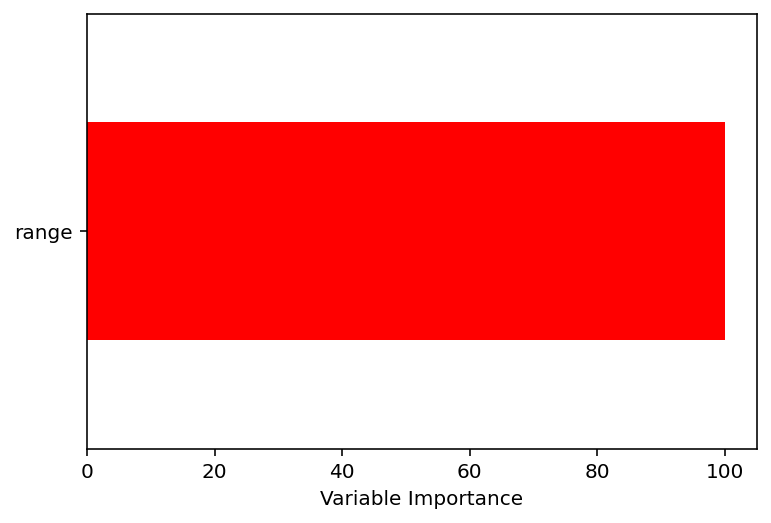

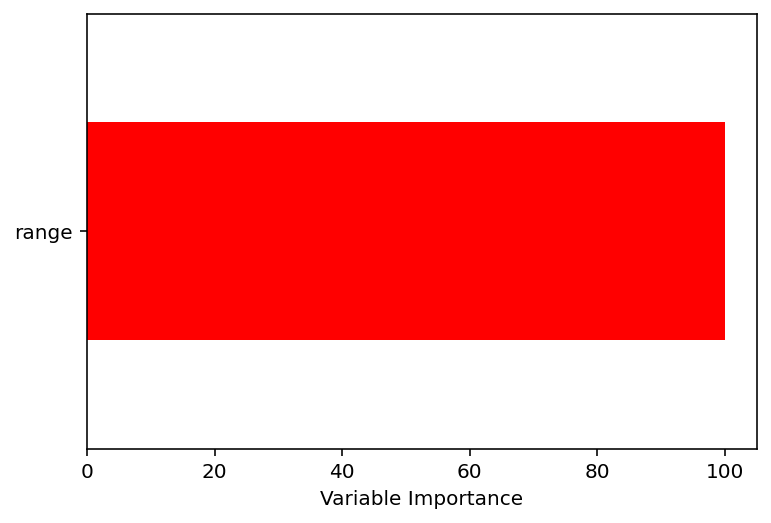

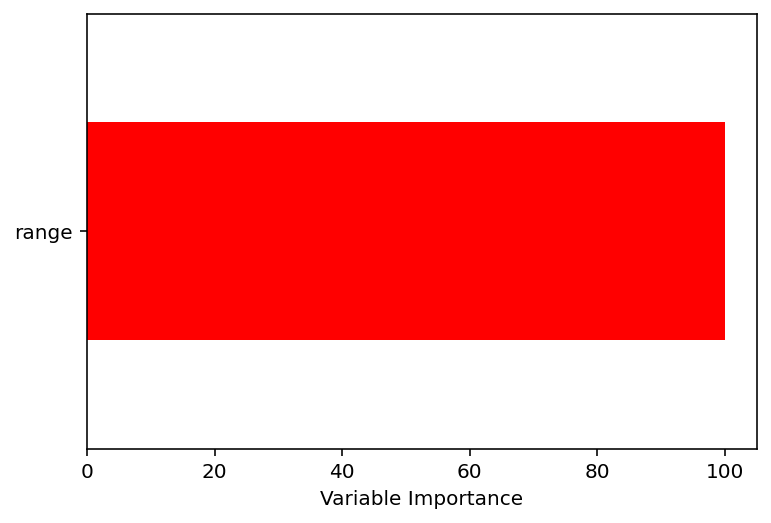

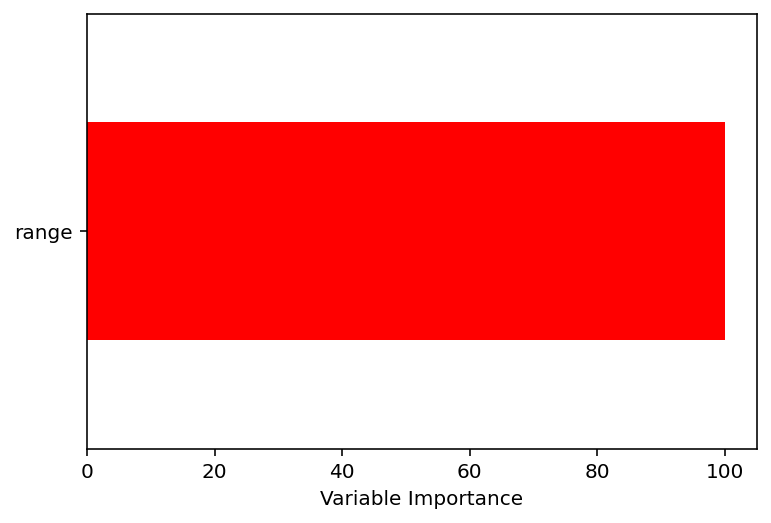

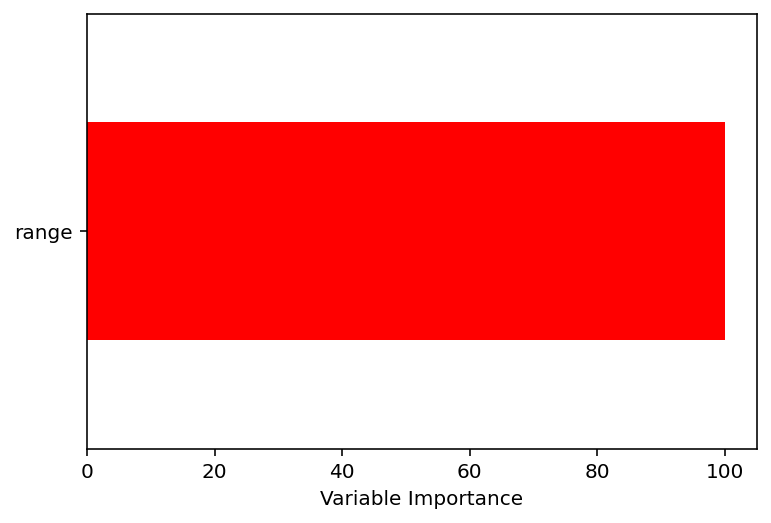

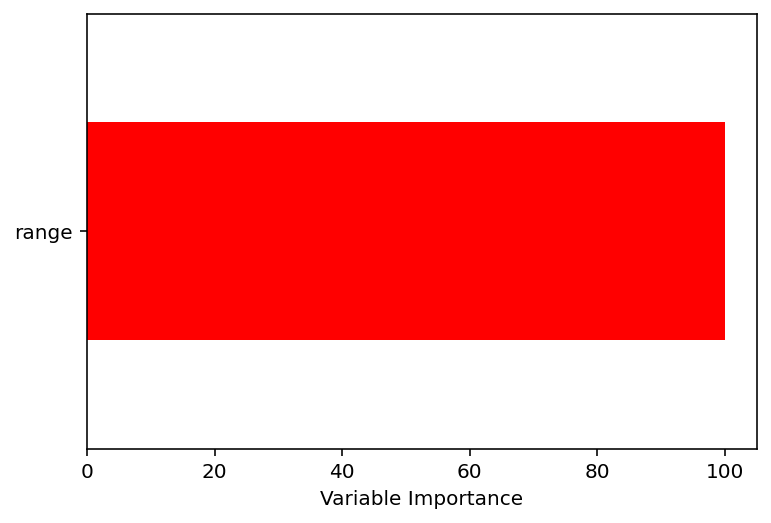

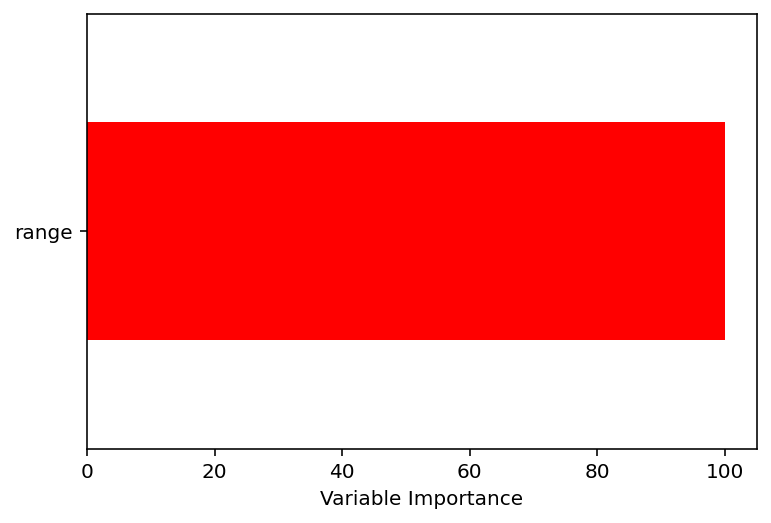

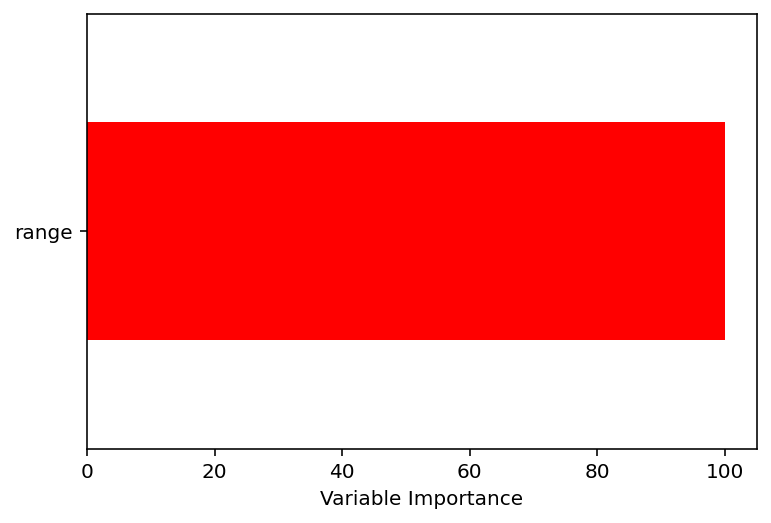

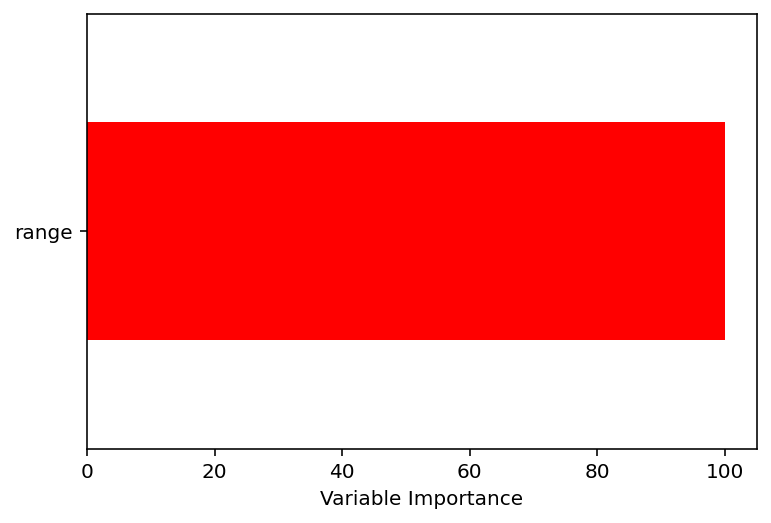

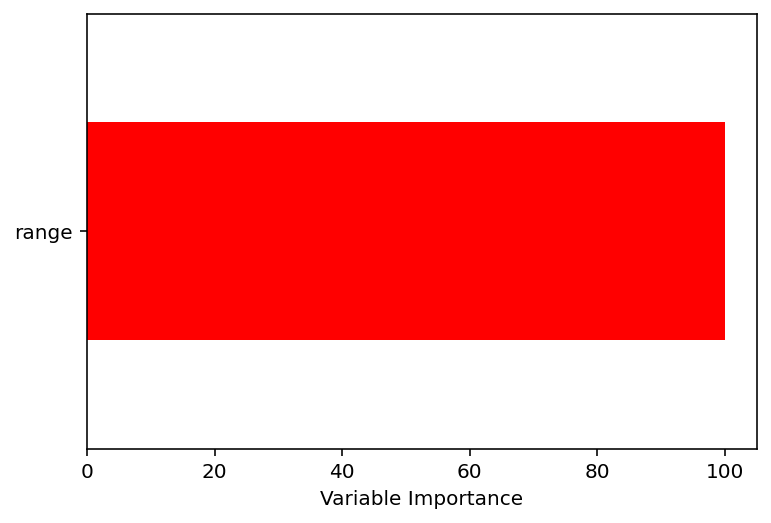

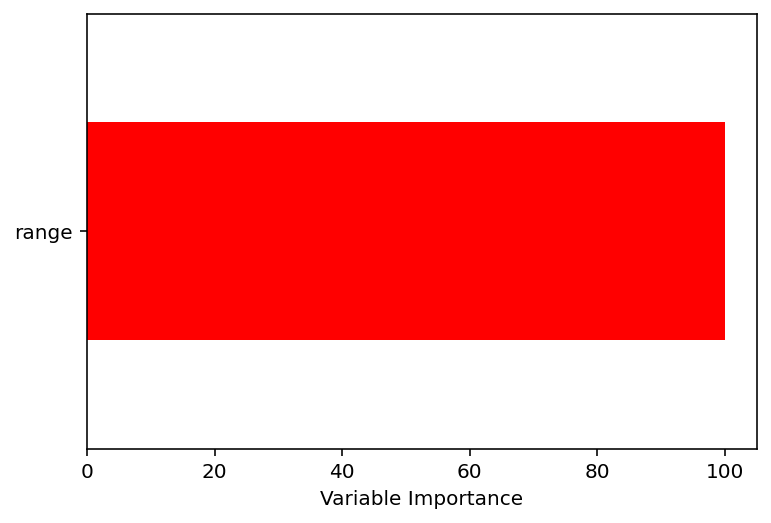

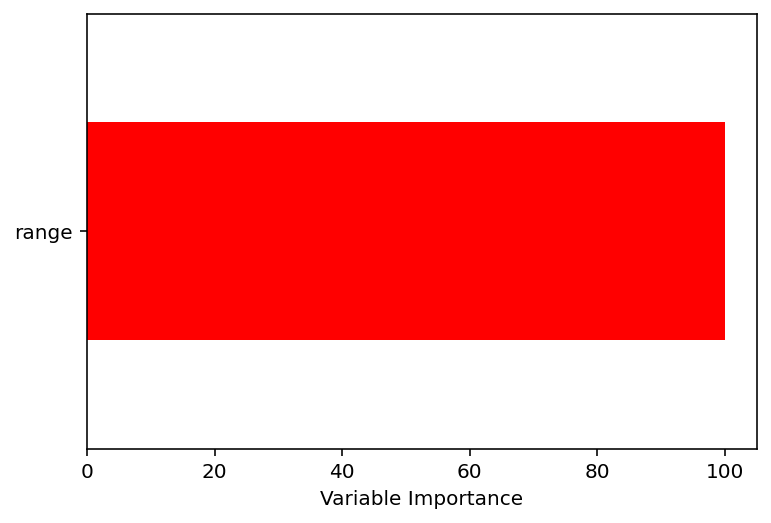

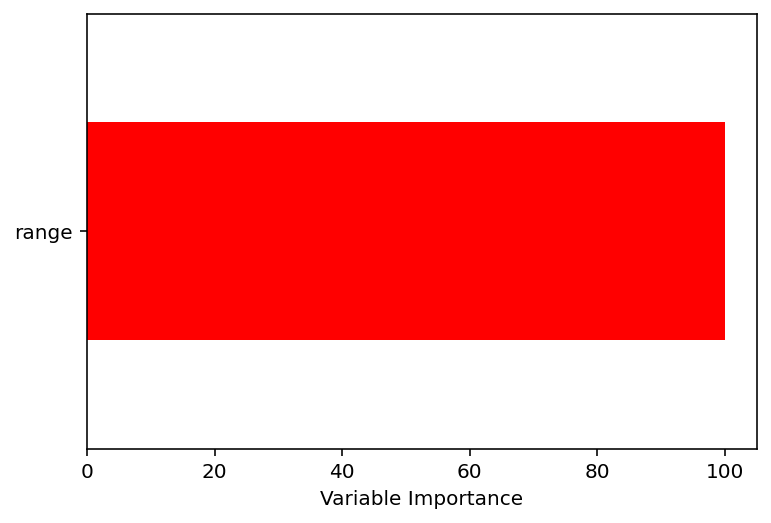

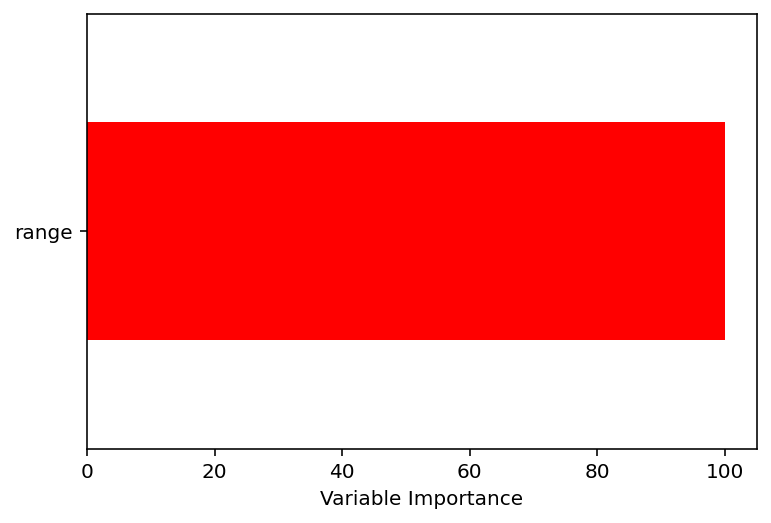

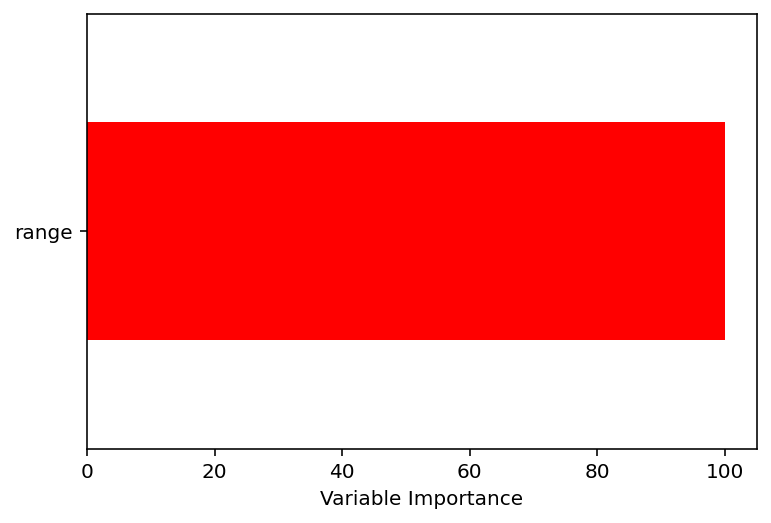

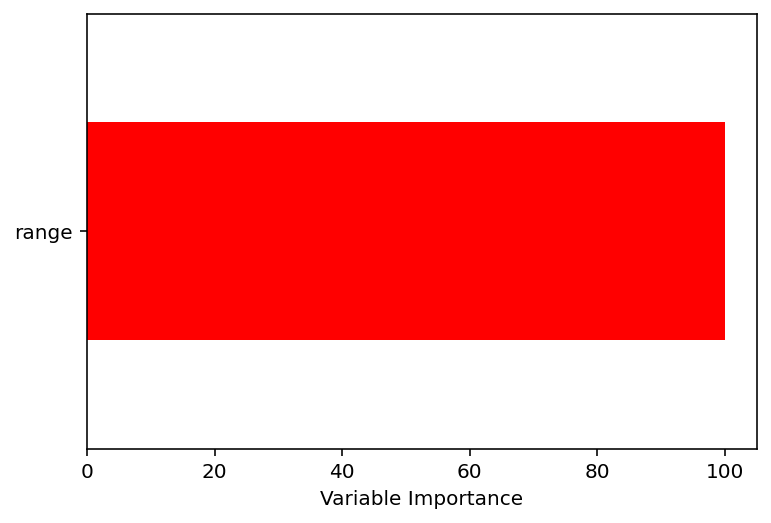

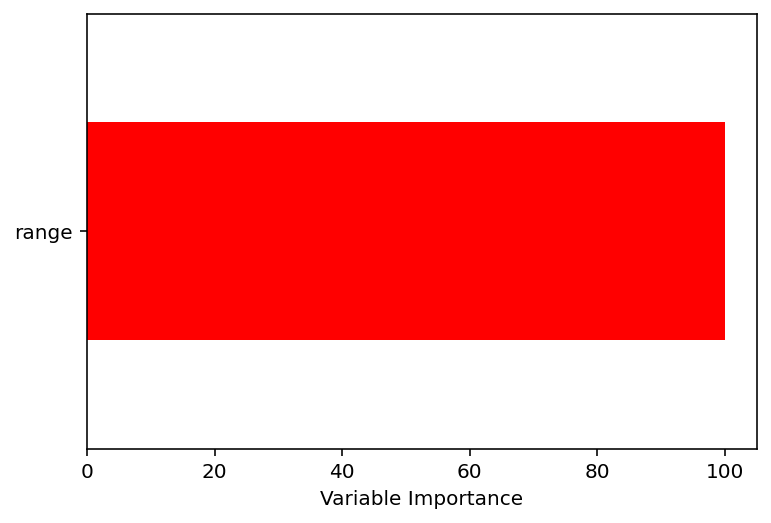

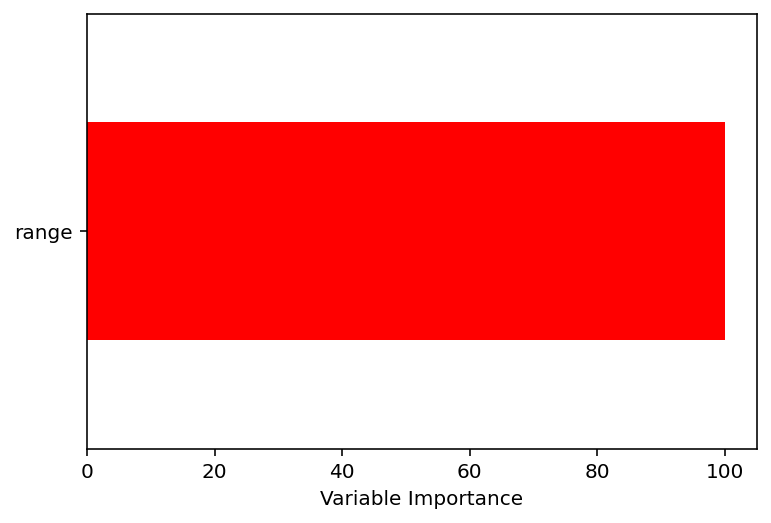

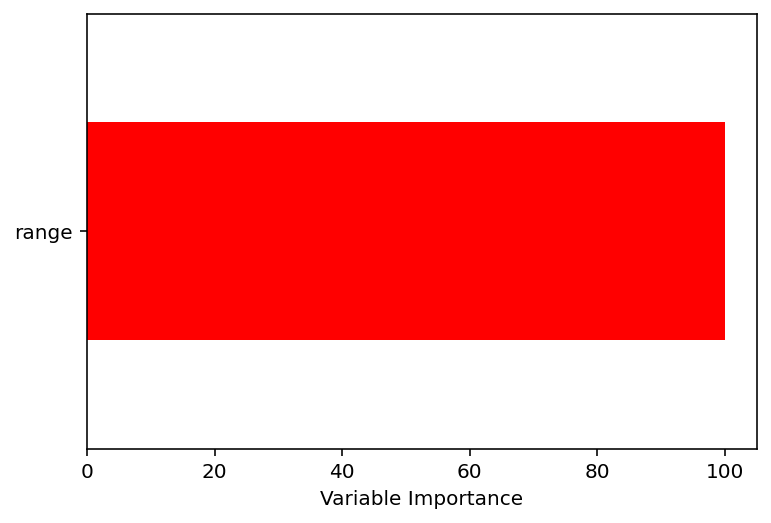

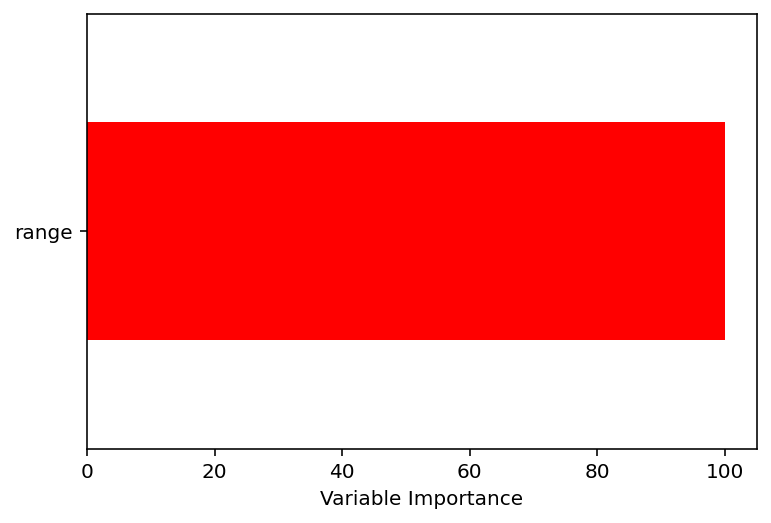

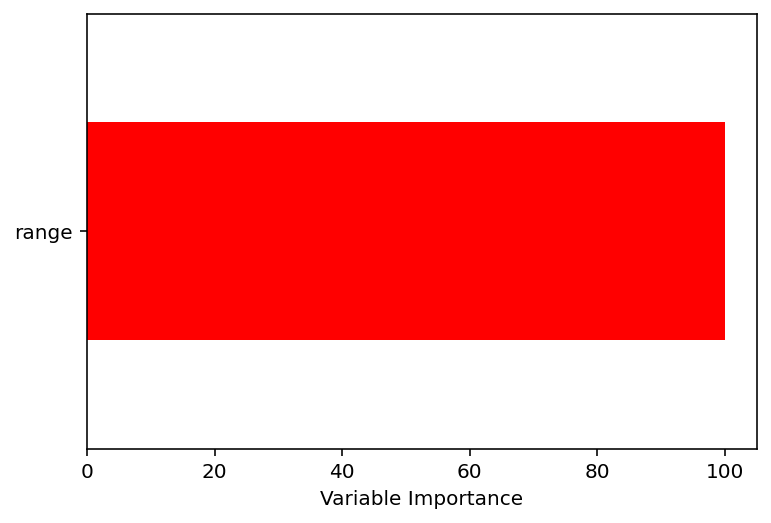

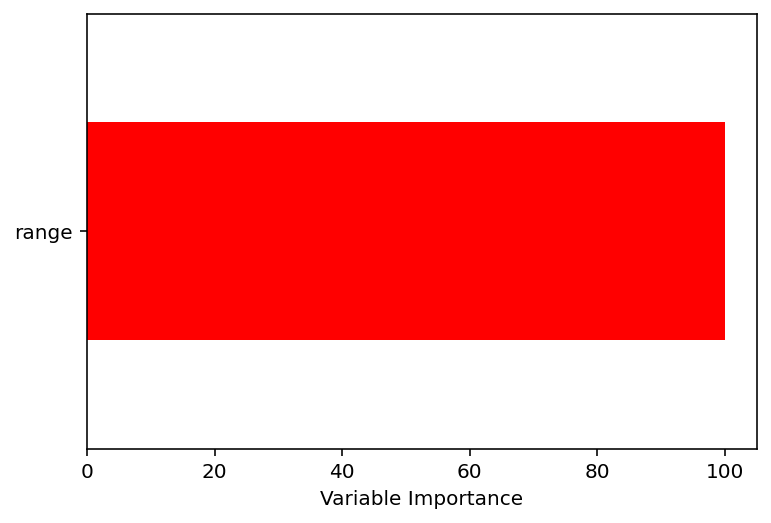

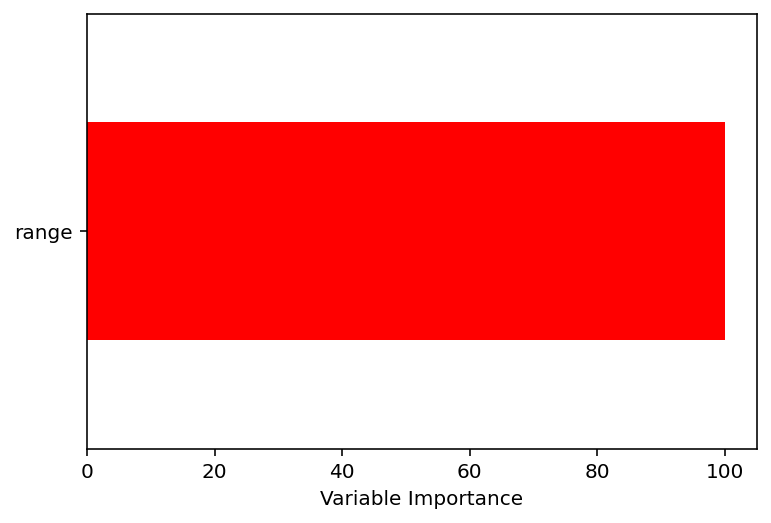

In [15]:
# LightGBM
lgbm = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [00:11<00:01,  1.80it/s]C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.82it/s]


---Run time is 12.659745599841699 seconds ---

Accuracy of each fold: 
 [0.38154477101845524, 0.7545869333074459, 0.9600301659125189, 0.8082537900056148, 0.39467403592513506, 0.8096350364963504, 0.3201075991930061, 0.957930921591095, 0.33863773357444243, 0.5711454617518826, 0.11209246538000218, 0.8875064800414723, 0.49869281045751634, 0.44483604045357034, 0.2926683291770574, 0.3760136577037986, 0.5239198808144347, 0.3197779319916724, 0.38653417156763337, 0.7119450317124736, 0.22919007251557552, 0.8723950468136514, 0.37724611346658593]

Avg accuracy : 
0.5360593252552779

Std of accuracy : 
0.2480958910906111
confusion matrix: 
[[71087 31798]
 [59241 25431]]
classification report: 
              precision    recall  f1-score   support

           0       0.55      0.69      0.61    102885
           1       0.44      0.30      0.36     84672

    accuracy                           0.51    187557
   macro avg       0.49      0.50      0.48    187557
weighted avg       0.50      0.51     

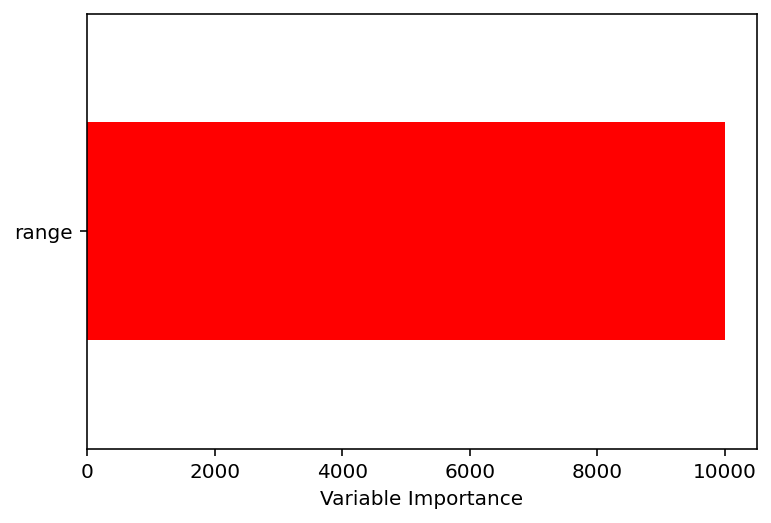

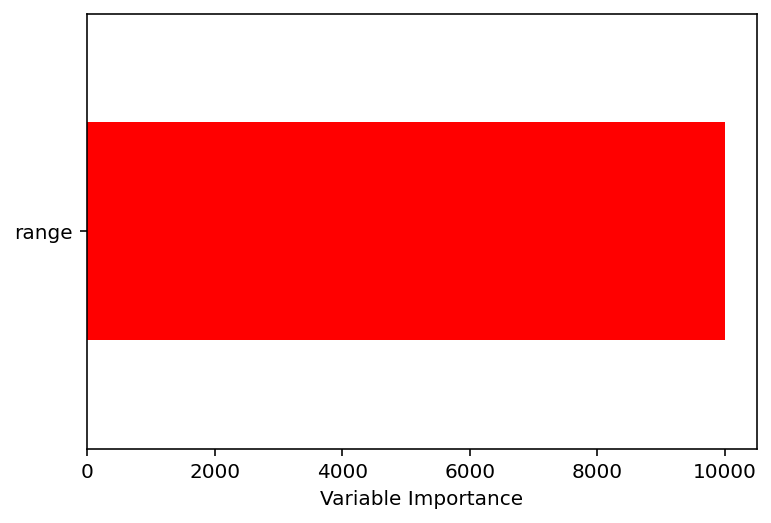

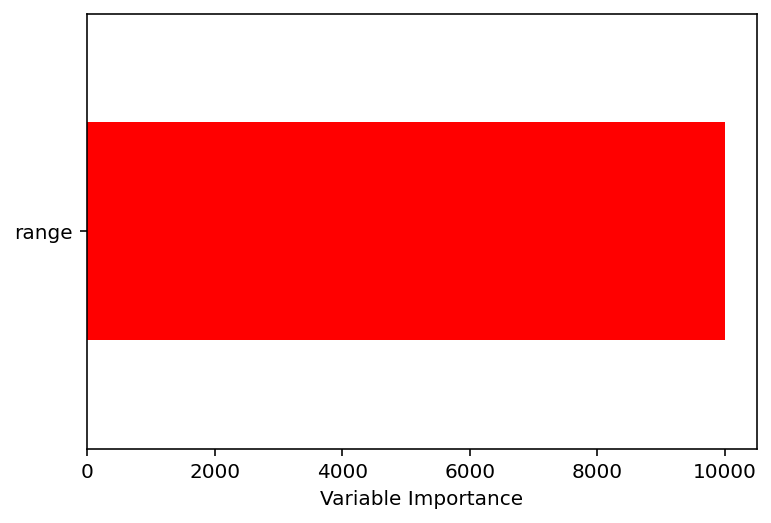

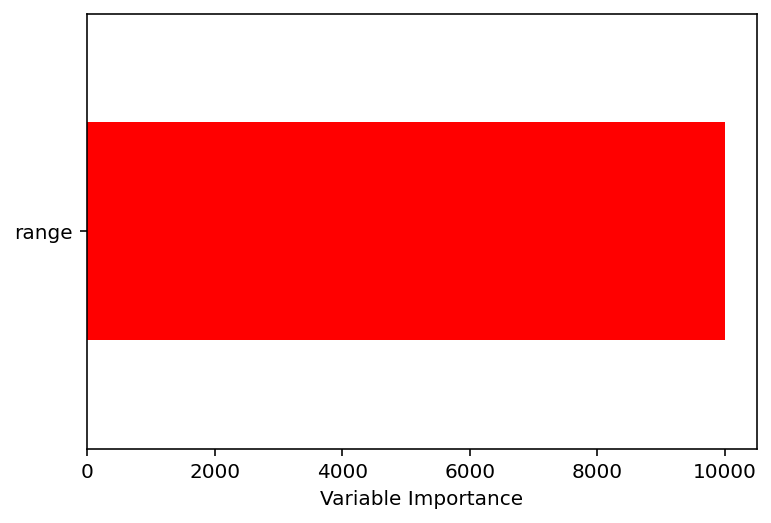

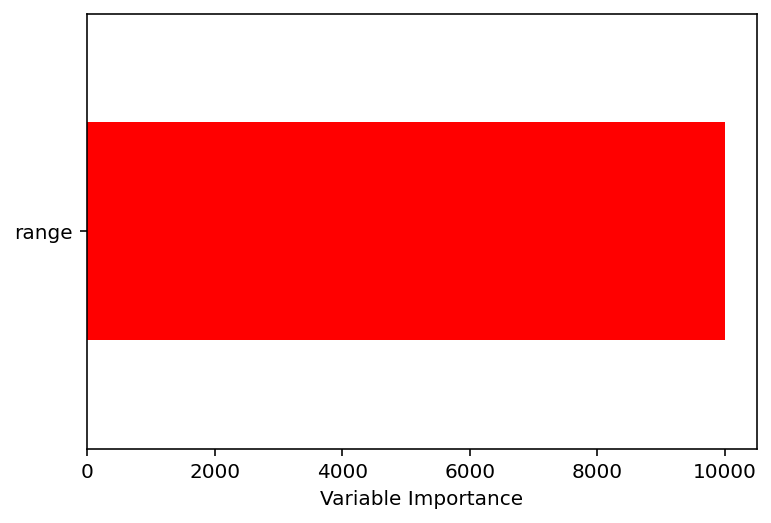

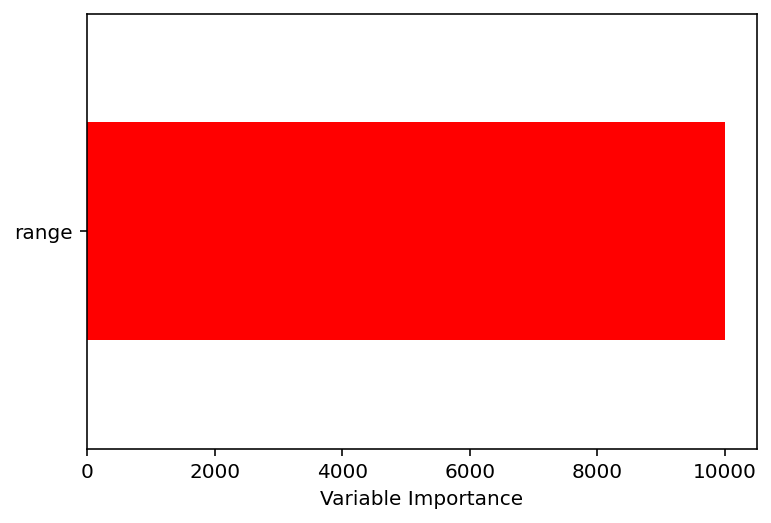

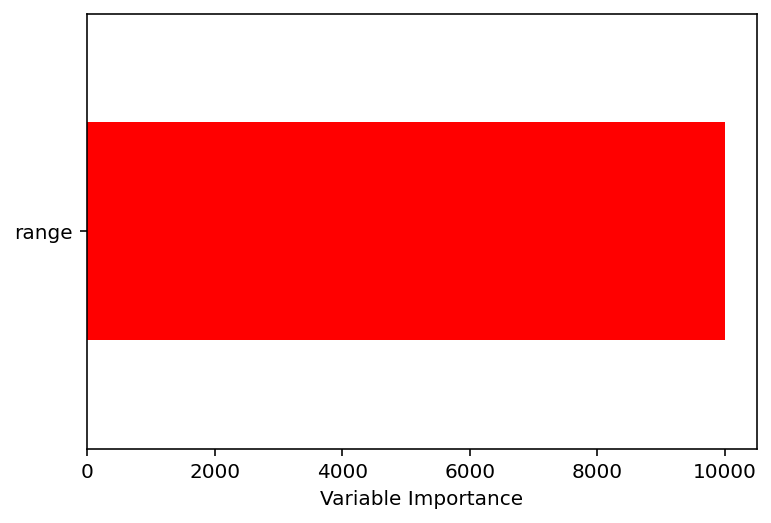

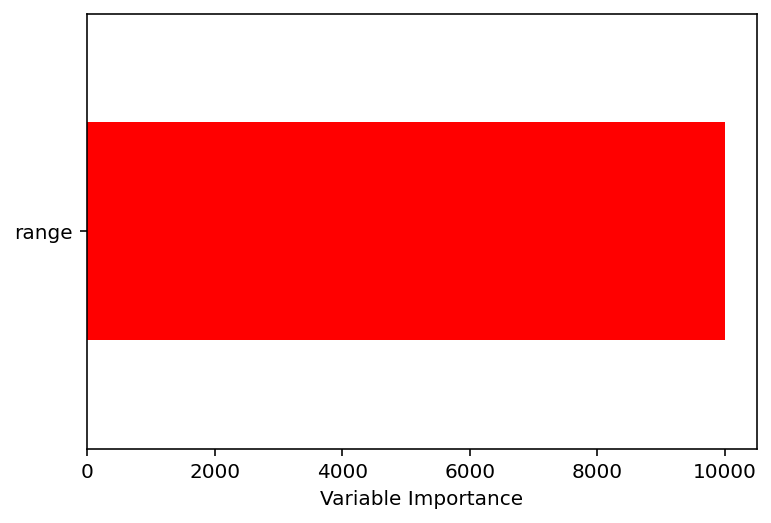

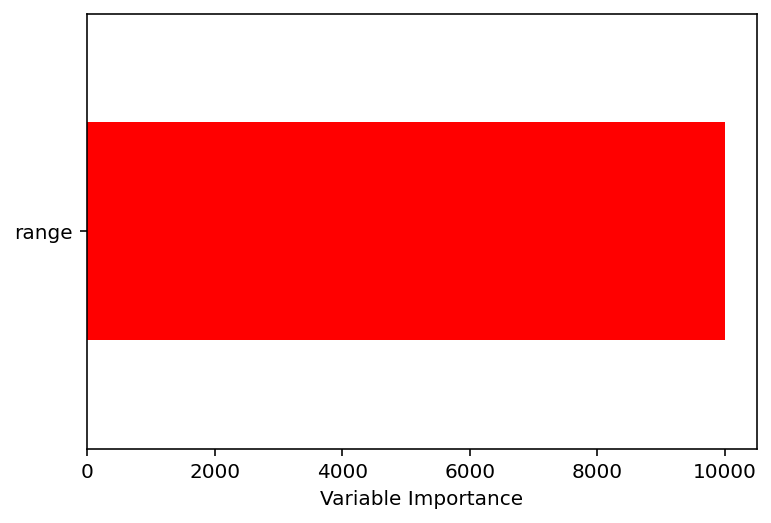

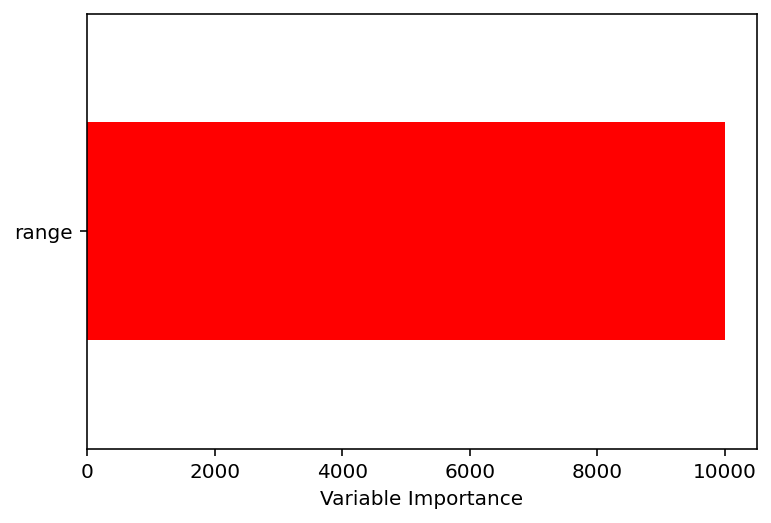

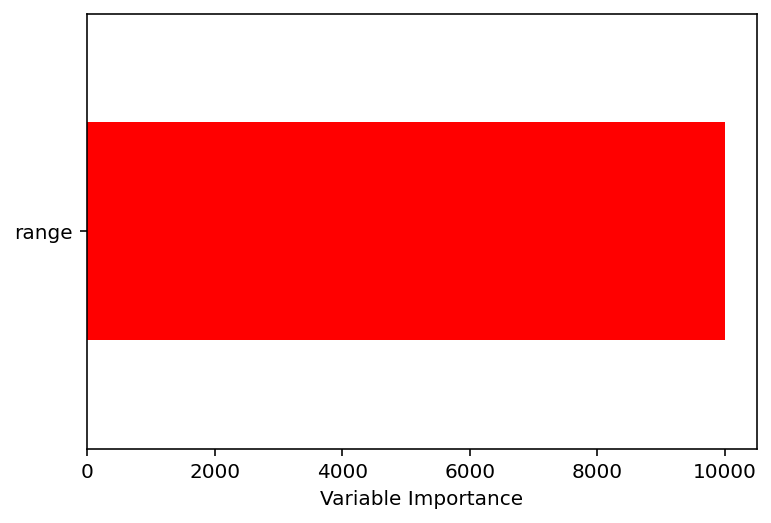

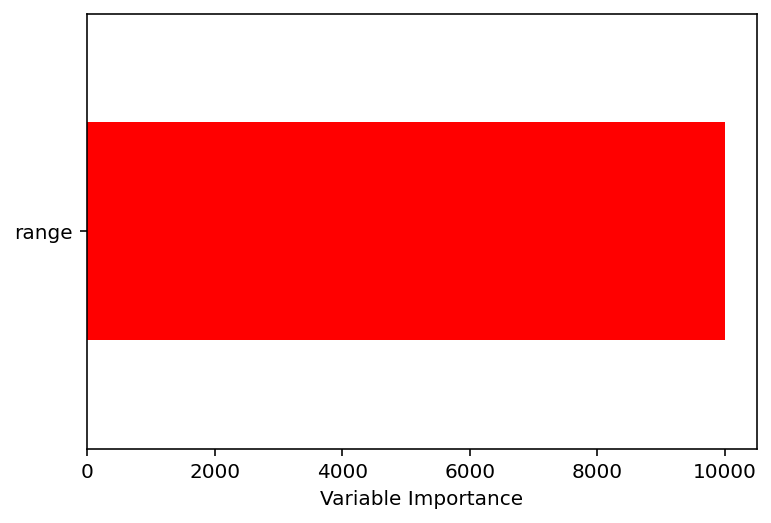

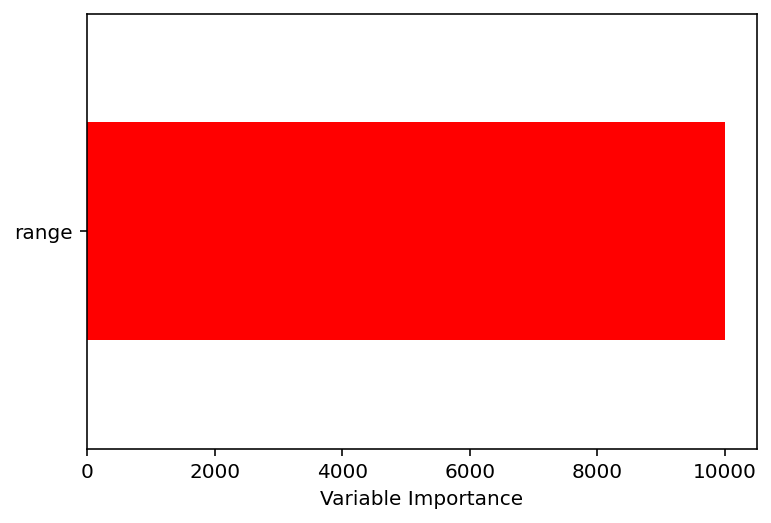

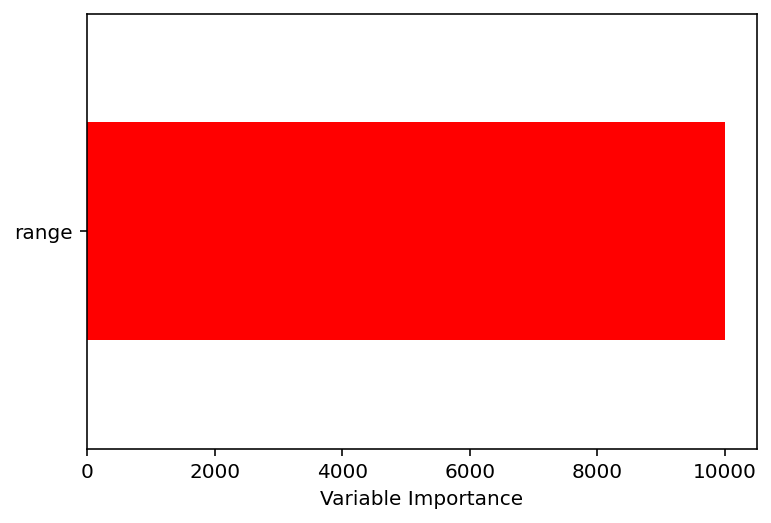

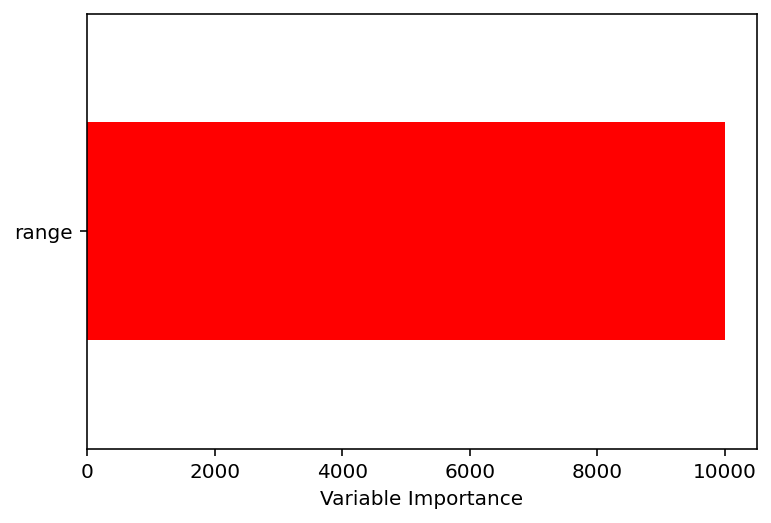

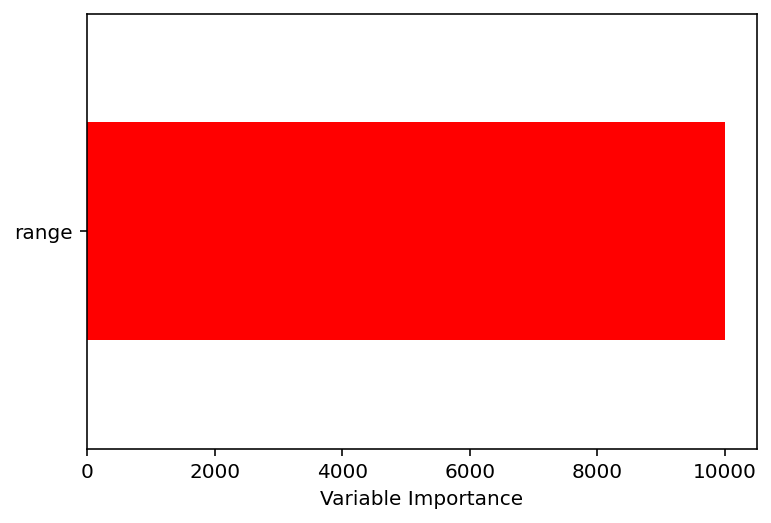

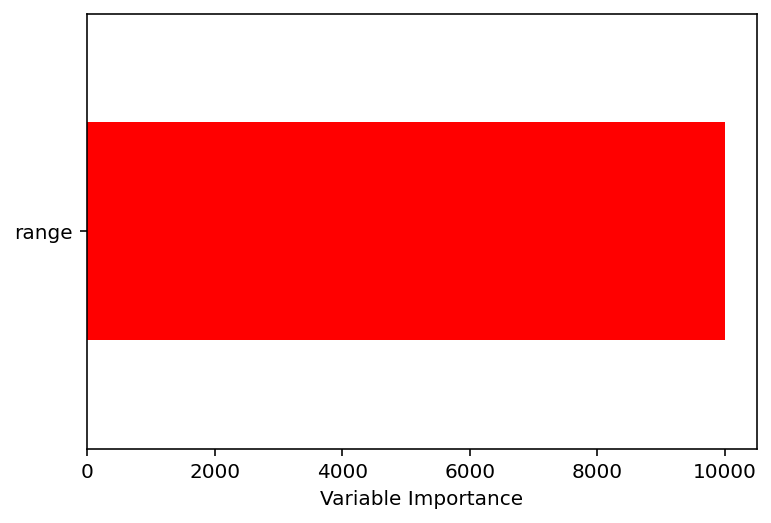

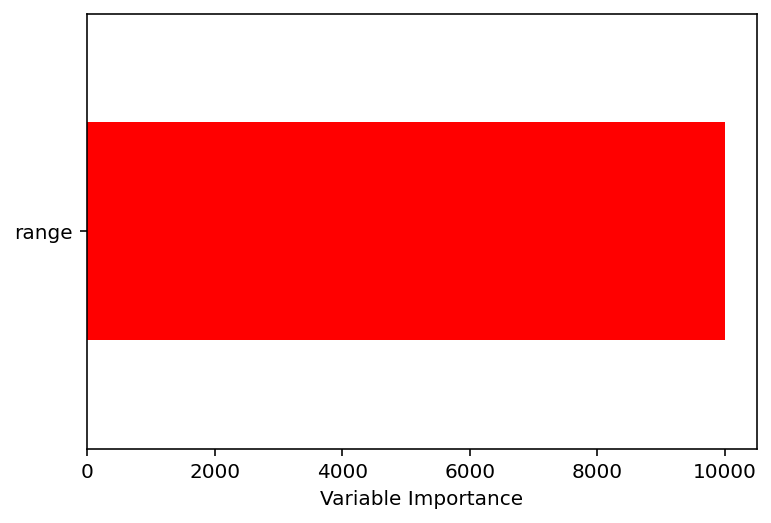

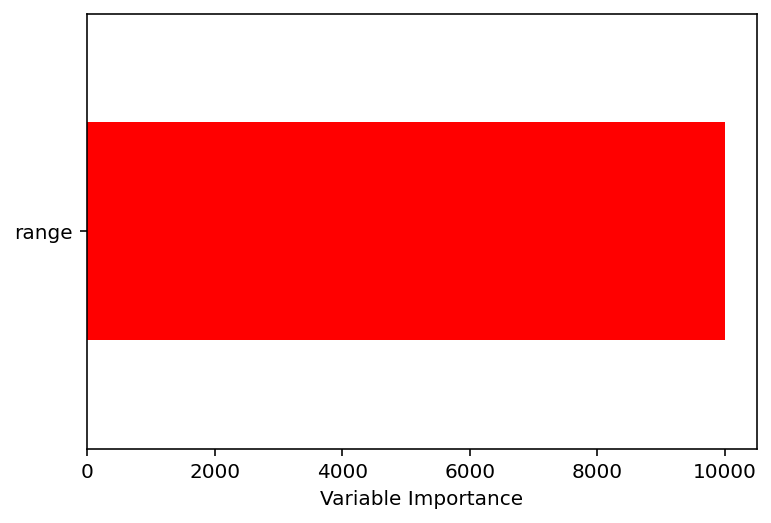

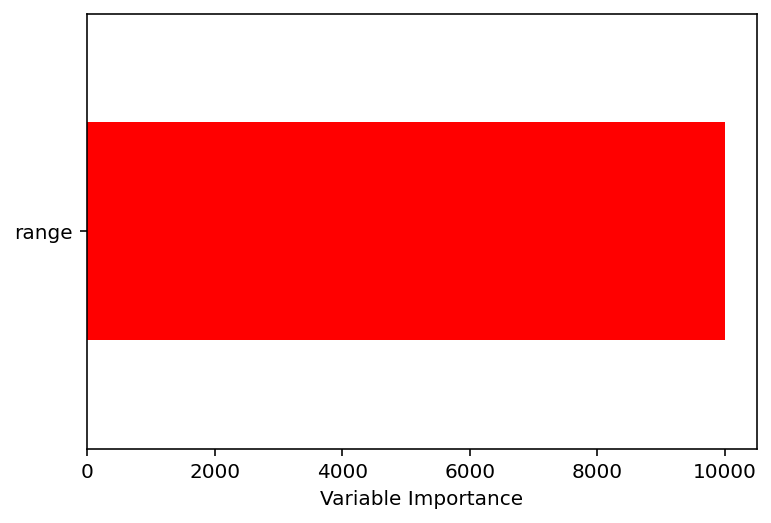

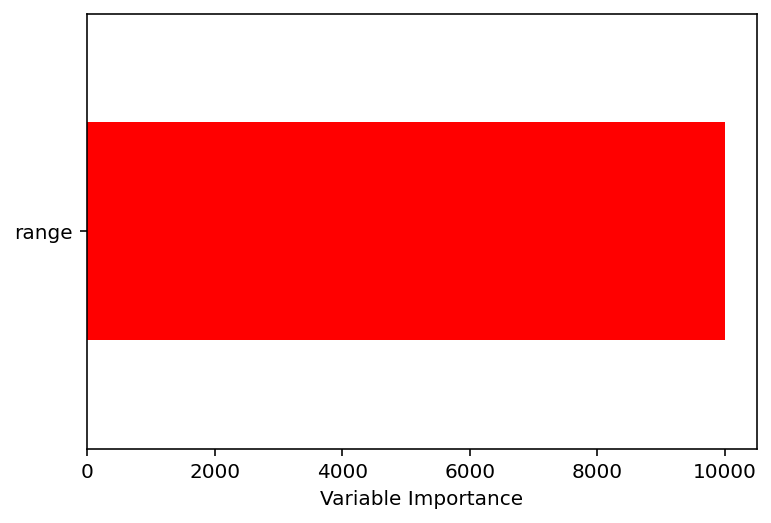

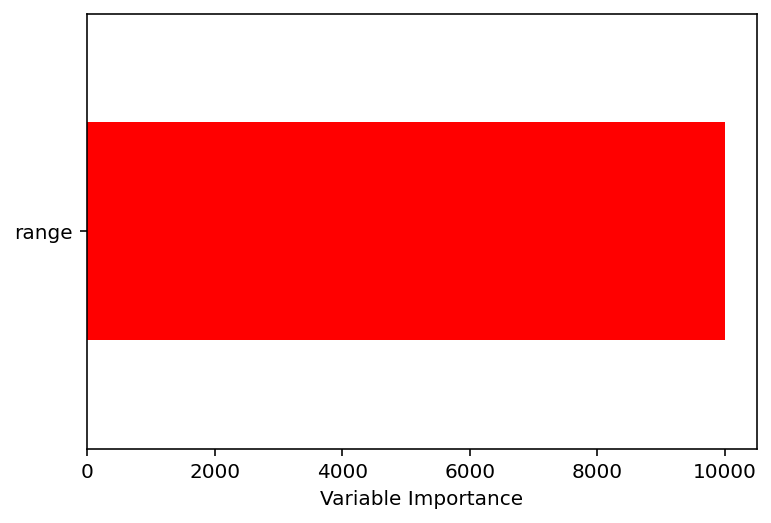

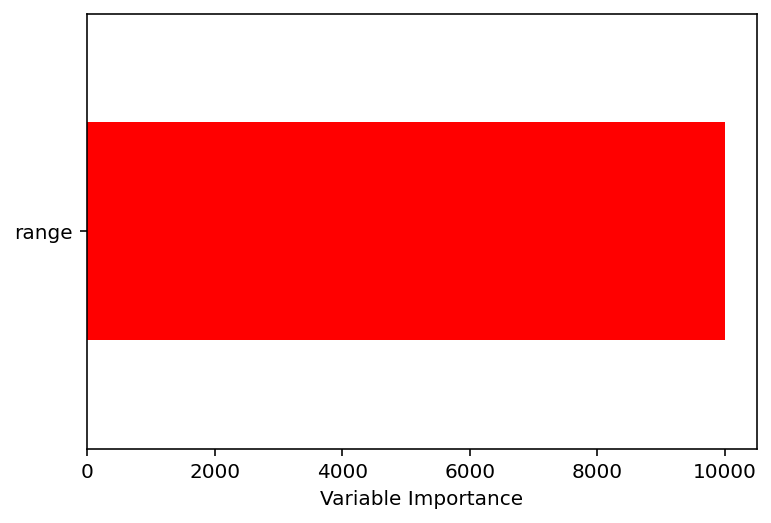

In [16]:
# CatBoost
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    # Create CatBoost model
    model = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           loss_function='Logloss')
    # train the model
    model.fit(X_train, y_train, verbose=False)
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

In [18]:
performance_df = pd.DataFrame(performance_dict)
performance_df

,Avg Accuracy,Std Accuracy,Sensitivity,Specificity,Precision,F1 score,Run time
0,0.551921,0.244999,0.695835,0.279943,0.593417,0.640558,91.731602
1,0.540157,0.240093,0.695835,0.301446,0.547587,0.612874,107.295792
2,0.536059,0.248096,0.690936,0.300347,0.545447,0.609632,12.659746
